In [2]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing

pd.set_option("display.max_columns", 100)

In [3]:
# Preprocess

# Check out each file. Content, images

root_path = "../input/indoor-location-navigation/"
train_paths = glob.glob(root_path + "train" + "/*/*/*")
test_paths = glob.glob(root_path + "test" + "/*")
metafiles = glob.glob(root_path + "metadata" + "/*")

print("No. Files in Train: {:,}".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,}".format(len(test_paths)), "\n" +
      "No. of metadata files: {:,}".format(len(metafiles)))

# Reading in 1 file
def pick_example(max_range, paths):
    ex = random.randint(0, max_range)
    example_path = paths[ex]
    path = f"{example_path}"
    paths = path.split("/")
    site = paths[4]
    floorNo = paths[5]
    floor_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_image.png"
    json_plan_filename = f"{root_path}metadata/{site}/{floorNo}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    return path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter

path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
print("example path: ", path)
print("site: ", site)
print("floorNo: ", floorNo)
print("floor_plan_filename: ", floor_plan_filename)
print("json_plan_filename: ", json_plan_filename)
print("width: {}, height: {} ".format(width_meter, height_meter))

with open(path) as p:
    lines = p.readlines()
print("No. Lines in 1 example: {:,}". format(len(lines)))

No. Files in Train: 26,925 
No. Files in Test: 626 
No. of metadata files: 204
example path:  ../input/indoor-location-navigation/train/5d27075f03f801723c2e360f/F2/5da96e2945eb0f0006d21373.txt
site:  5d27075f03f801723c2e360f
floorNo:  F2
floor_plan_filename:  ../input/indoor-location-navigation/metadata/5d27075f03f801723c2e360f/F2/floor_image.png
json_plan_filename:  ../input/indoor-location-navigation/metadata/5d27075f03f801723c2e360f/F2/floor_info.json
width: 292.37655429070344, height: 222.0824509676249 
No. Lines in 1 example: 20,908


In [4]:
# for line in lines[:200]:
#     print(line)

In [5]:
# using github repo in kaggle kernels
# https://www.kaggle.com/getting-started/71642
!cp -r ../input/indoorlocationcompetition20master/indoor-location-competition-20-master/* ./

In [6]:
# Import custom function from the repository
from io_f import read_data_file

# Read in 1 random example
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
sample_file = read_data_file(path)

# You can access the information for each variable:
# Each data is split for time
# Metadata is expressed with "#"

# for i in sample_file.acce[:, [0]]:
#     print(i)
#     print(int(i))

# print("~~~ Example ~~~")
# print("acce: {}".format(sample_file.acce), "\n" +
#       "acce shape: {}".format(sample_file.acce.shape), "\n" +
#       "acacce_uncalice: {}".format(sample_file.acce_uncali), "\n" +
#       "acacce_uncalice shape: {}".format(sample_file.acce_uncali.shape), "\n" +
#       "ahrs: {}".format(sample_file.ahrs), "\n" +
#       "ahrs shape: {}".format(sample_file.ahrs.shape), "\n" +
#       "gyro: {}".format(sample_file.gyro), "\n" +
#       "gyro shape: {}".format(sample_file.gyro.shape), "\n" +
#       "gyro_uncali: {}".format(sample_file.gyro_uncali), "\n" +
#       "gyro_uncali shape: {}".format(sample_file.gyro_uncali.shape), "\n" +
#       "ibeacon: {}".format(sample_file.ibeacon), "\n" +
#       "ibeacon shape: {}".format(sample_file.ibeacon.shape), "\n" +
#       "magn: {}".format(sample_file.magn), "\n" +
#       "magn shape: {}".format(sample_file.magn.shape), "\n" +
#       "magn_uncali: {}".format(sample_file.magn_uncali), "\n" +
#       "magn_uncali shape: {}".format(sample_file.magn_uncali.shape), "\n" +
#       "waypoint: {}".format(sample_file.waypoint), "\n" +
#       "waypoint shape: {}".format(sample_file.waypoint.shape), "\n" +
#       "wifi: {}".format(sample_file.wifi), "\n" +
#       "wifi shape: {}".format(sample_file.wifi.shape))

In [7]:
def show_site_png(root_path, site):
    floor_paths = glob.glob(root_path + "metadata/" + site + "/*/floor_image.png")
    n = len(floor_paths)
    print("No. of floor paths: ", n)

    # Create the custom number of rows & columns
    ncols = [ceil(n / 3) if n > 4 else 4][0]
    nrows = [ceil(n / ncols) if n > 4 else 1][0]

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Site no. '{site}'", fontsize=18)

    # Plot image for each floor
    for k, floor in enumerate(floor_paths):
        # plt.subplot(nrows, ncols, k+1)
        plt.subplot(ncols, nrows, k+1)
        plt.rcParams["figure.facecolor"] = "white"

        image = Image.open(floor)

        plt.imshow(image)
        plt.axis("off")
        title = floor.split("/")[5]
        plt.title(title, fontsize=15)

No. of floor paths:  12


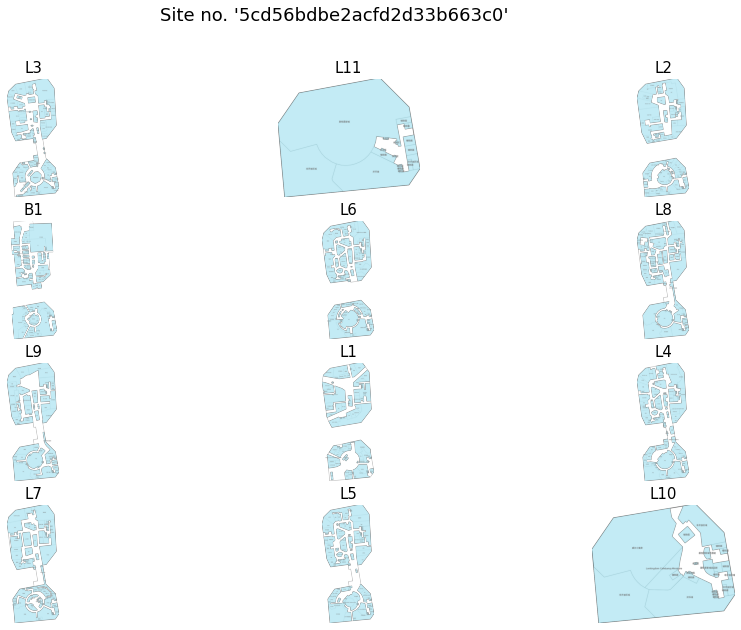

In [8]:
path, site, floorNo, floor_plan_filename, json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)
show_site_png(root_path, site=site)

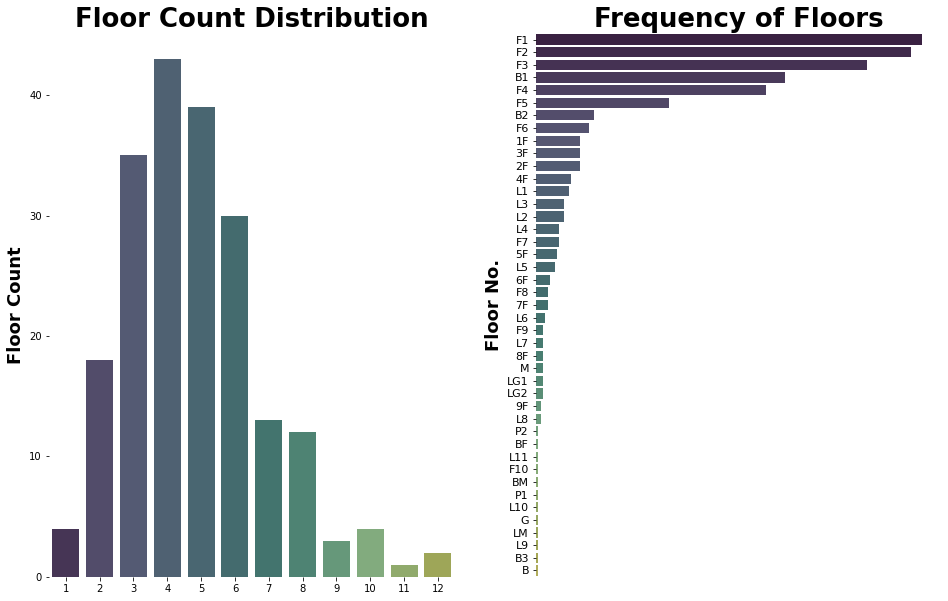

In [9]:
# Checking the floor number distribution

all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
all_sites = glob.glob("../input/indoor-location-navigation/metadata/*")
floor_no = []
floor_counts = []

# Floor count
for site in all_sites:
    floor_count = len([name for name in os.listdir(site)])
    floor_counts.append(floor_count)

floor_counts_df = pd.DataFrame(floor_counts, columns=["F_Count"])
floor_counts_df = floor_counts_df["F_Count"].value_counts().reset_index()
floor_counts_df = floor_counts_df.sort_values("index", ascending=True)

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

# ToDo: Floor expressions need to be fixed
# 1F -> F1, L1 -> F1, G -> F1 etc

# Plot
# display(floor_counts_df.head(10))

fig, axes = plt.subplots(ncols=2, figsize=(16, 10))
axes[0] = sns.barplot(data=floor_counts_df, x="index", y="F_Count", palette="viridis", saturation=0.4, ax=axes[0])
axes[0].set_title("Floor Count Distribution", size = 26, weight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Floor Count", size = 18, weight="bold")

axes[1] = sns.barplot(data=floor_no, x="No", y="index", palette="viridis", saturation=0.4, ax=axes[1])
axes[1].set_title("Frequency of Floors", size = 26, weight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Floor No.", size = 18, weight="bold")

plt.xticks([])
plt.yticks(fontsize=11)
sns.despine(left=True, bottom=True);

No. of geojson file: 981
File path: ../input/indoor-location-navigation/metadata/5cd56c18e2acfd2d33b6c321/L4/geojson_map.json
SiteID: 5cd56c18e2acfd2d33b6c321
Floor: L4
Floor info: {'Vr': '000200', 'category': 'floor', 'name': 'L4', 'code': 'GD0001530110400004', 'floor_num': 4, 'type': 'floor'}


'floor_num_df length: 981'

site_id floor_no  floor_no_json
0  5cd56c0ce2acfd2d33b6ab27       B1           -1.0
1  5cd56c0ce2acfd2d33b6ab27       F3            3.0
2  5cd56c0ce2acfd2d33b6ab27       F2            2.0
3  5cdbc652853bc856e89a8694       B1           -1.0
4  5cdbc652853bc856e89a8694       F1            1.0

<Figure size 432x288 with 0 Axes>

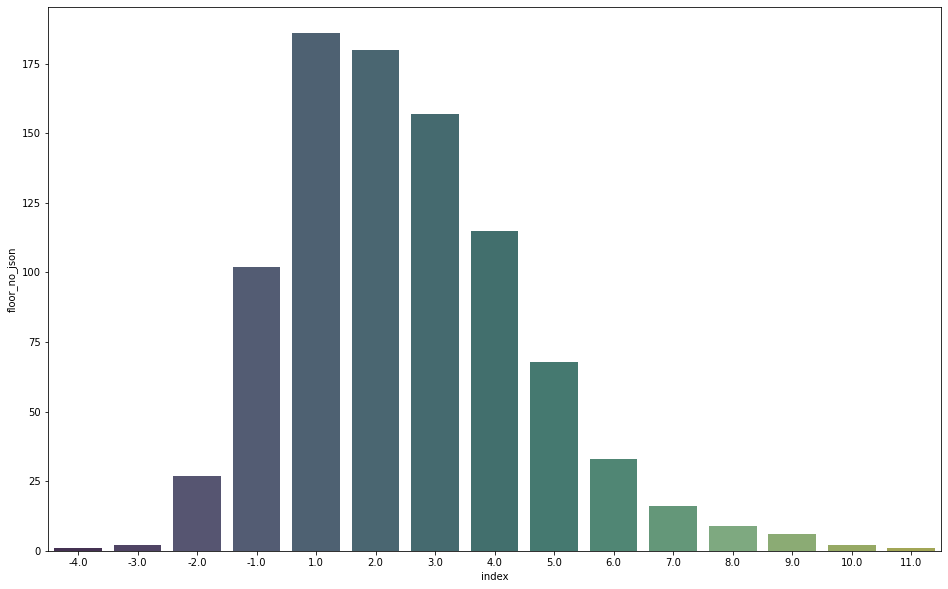

In [10]:
# Metadata checking (GeoJSON)
# This is a vector representation of floor map
geojson_paths = glob.glob("../input/indoor-location-navigation/metadata/*/*/geojson_map.json")
print("No. of geojson file: {}".format(len(geojson_paths)))

# Print one example
ex = random.randint(0, len(geojson_paths))
geojson_file_name = geojson_paths[ex]
with open(geojson_file_name) as json_file:
    paths = geojson_file_name.split("/")
    site_id = paths[4]
    floor = paths[5]
    json_data = json.load(json_file)
    json_properties = json_data["features"][0]["properties"]
    print("File path: {}".format(geojson_file_name))
    print("SiteID: {}".format(site_id))
    print("Floor: {}".format(floor))
    print("Floor info: {}".format(json_properties))

# create id and floor number matching file
site_ids = []
floor_no = []
floor_no_json = []

for i in range(0, len(geojson_paths)):
    with open(geojson_paths[i]) as f:
        paths = geojson_paths[i].split("/")
        site_id = paths[4]
        floor = paths[5]
        site_ids.append(site_id)
        floor_no.append(floor)
        d = json.load(f)
        try:
            floor_no_json.append(d["features"][0]["properties"]["floor_num"])
        except:
            floor_no_json.append(np.nan)

floor_num_df = pd.DataFrame(
    {"site_id": site_ids,
     "floor_no": floor_no,
     "floor_no_json": floor_no_json,
    })

display("floor_num_df length: {}".format(len(floor_num_df)))
display(floor_num_df.head())

# Get floormap dict to be used later
floor_map_pairs = list(zip(floor_num_df["floor_no"], floor_num_df["floor_no_json"]))
floor_map_pairs = np.unique(floor_map_pairs, axis=0) # get unique pair
# print(floor_map_pairs) # to be used as floor_map later

# Plot distribution
floor_num_count_df = floor_num_df["floor_no_json"].value_counts().reset_index()
floor_num_count_df = floor_num_count_df.sort_values("floor_no_json", ascending=False)
# display(floor_num_count_df)
# print(len(floor_num_count_df["floor_no_json"] == np.nan))

fig = plt.figure()
ax = plt.subplots(figsize=(16, 10))
sns.barplot(data=floor_num_count_df, x="index", y="floor_no_json", palette="viridis", saturation=0.4)
fig.show()

# Just in case: Need for altitude info in geoJSON
# from pyproj import Proj, transform
# print(transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), -0.1285907, 51.50809))  # longitude first, latitude second.
# output (meters east of 0, meters north of 0): (-14314.651244750548, 6711665.883938471)

Processing ../input/indoor-location-navigation/train/5da958dd46f8266d0737457b/B1/5dae7819aa1d300006faac7e.txt...
Waypoints: [[1.57171472e+12 1.01231186e+02 1.38075930e+02]
 [1.57171473e+12 1.06860510e+02 1.36809430e+02]
 [1.57171474e+12 1.00302860e+02 1.30306350e+02]]



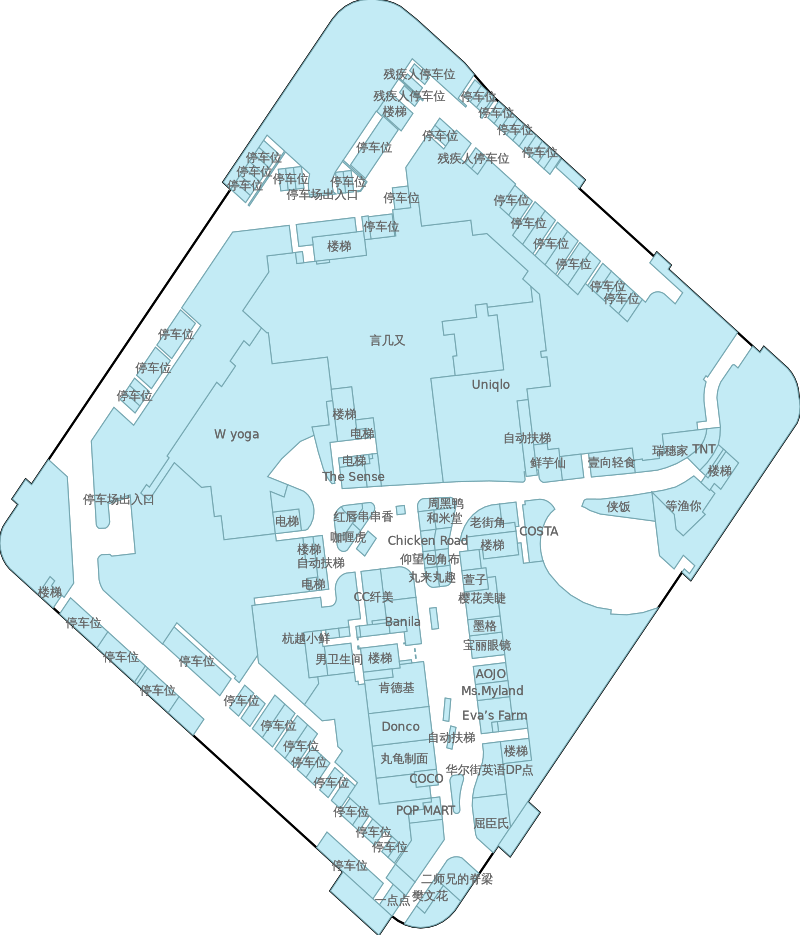

In [11]:
# More viz on accelerometers, wifi etc in one go
from visualize_f import visualize_trajectory, visualize_heatmap
from main import extract_wifi_rssi, extract_wifi_count
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from main import extract_ibeacon_rssi

# Visualizing magnetic strength
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# extract mag, wifi, beacon of one example
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position([path])
magnetic_strength = extract_magnetic_strength(mwi_datas)
wifi_rssi = extract_wifi_rssi(mwi_datas)
wifi_counts = extract_wifi_count(mwi_datas)
ibeacon_rssi = extract_ibeacon_rssi(mwi_datas)
ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]

# positions for heatmap
heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))
heat_positions_wifi = np.array(list(wifi_counts.keys()))
heat_values_wifi = np.array(list(wifi_counts.values()))
heat_positions_bc = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values_bc = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# filter out positions that no wifi detected
mask = heat_values_wifi != 0
heat_positions_wifi = heat_positions_wifi[mask]
heat_values_wifi = heat_values_wifi[mask]

# get trajectory
example = read_data_file(path)
trajectory = example.waypoint # Returns timestamp, x, y values
print(f"Waypoints: {trajectory}")
trajectory = trajectory[:, 1:3] # Removes timestamp (we only need the coordinates)

# Plot trajectory
visualize_trajectory(trajectory = trajectory,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = "Example of Waypoint",)


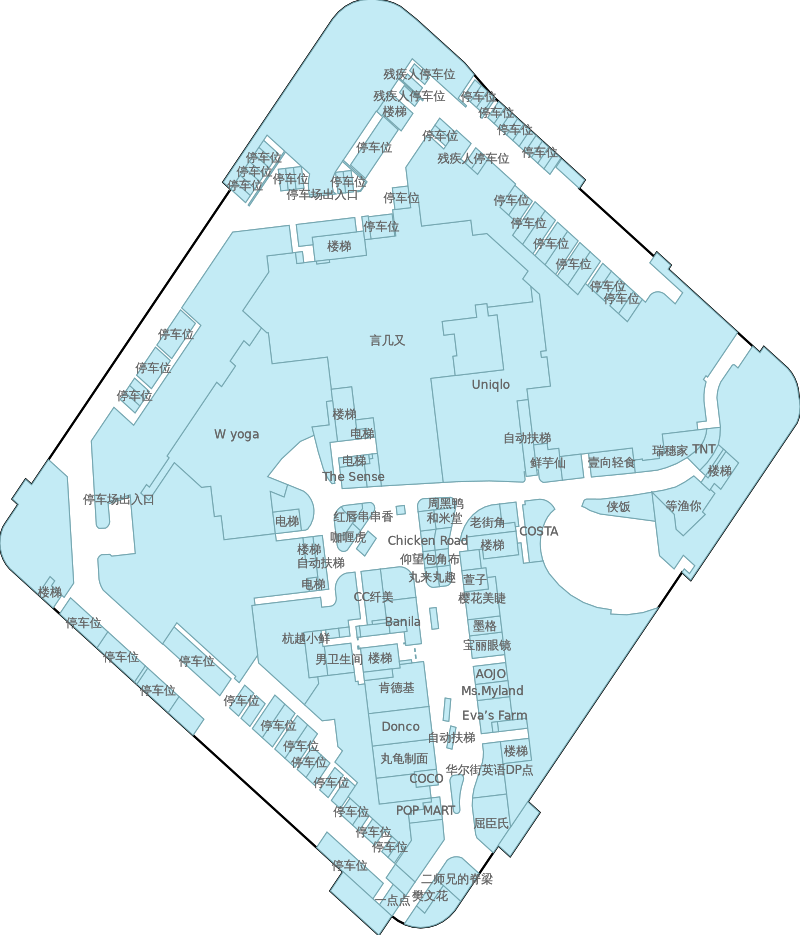

In [12]:
# plot magnnetic strength
visualize_heatmap(heat_positions,
                  heat_values,
                  floor_plan_filename,
                  width_meter, 
                  height_meter, 
                  colorbar_title='mu tesla', 
                  title='Magnetic Strength')

This floor has 134 wifi aps (access points).



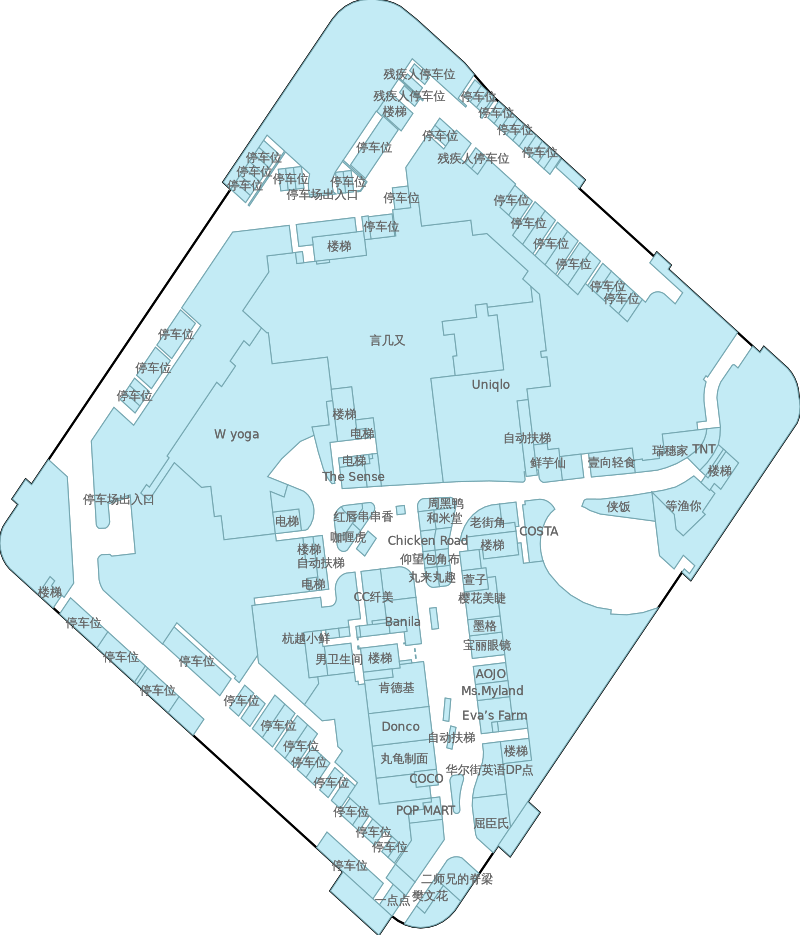

In [13]:
# WiFi data
print(f'This floor has {len(wifi_rssi.keys())} wifi aps (access points).')
visualize_heatmap(heat_positions_wifi, 
                  heat_values_wifi, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='count', 
                  title=f'WiFi Count')

This floor has 32 ibeacons.



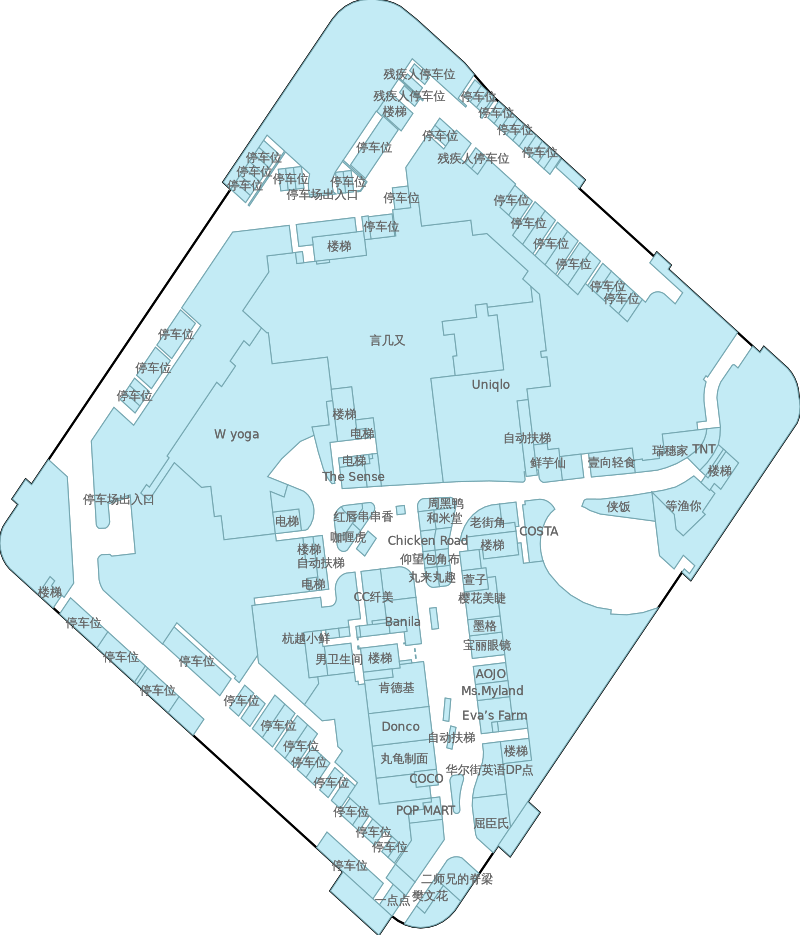

In [14]:
# The heatmap
print(f'This floor has {len(ibeacon_rssi.keys())} ibeacons.')
visualize_heatmap(heat_positions_bc,
                  heat_values_bc,
                  floor_plan_filename,
                  width_meter,
                  height_meter,
                  colorbar_title='dBm',
                  title='iBeacon RSSE')

In [15]:
# Try working out step_positions for 1 trace file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

path_datas = read_data_file(path)
acce_datas = path_datas.acce
magn_datas = path_datas.magn
ahrs_datas = path_datas.ahrs
wifi_datas = path_datas.wifi
ibeacon_datas = path_datas.ibeacon
posi_datas = path_datas.waypoint # not to be used

# Feature candidate
# You can't get the waypoint in test, so use acce and ahrs data to calculate relative positions
def calc_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    # only use del if we don't need timestamps
    # rel_positions_del = np.delete(rel_positions, 0, 1)
    return rel_positions

rel_positions = calc_rel_positions(acce_datas, ahrs_datas)
print(acce_datas[0])
print(rel_positions[0])

# # For accelerometer and ahrs coordinates visualization
# step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
# step_positions_del = np.delete(step_positions, 0, 1)
# temp_values = np.ones((step_positions.shape[0]))

# # Feature candidate
# # Calculate relative position from magnetic strengths and wifi
# def calc_mag_positions(magn_datas):
#     sep_tss = np.unique(magn_datas[:, 0].astype(float))
#     magn_datas_list = split_ts_seq(magn_datas, sep_tss)
#     return magn_datas_list

# mag_positions = calc_mag_positions(magn_datas)
# print(magn_datas)
# print(mag_positions)
# print(len(mag_positions))

# # Feature candidate
# # Calculate relative position from wifi and beacon
# def calc_wifi_positions():

[1.57171472e+12 4.60205080e-02 1.96983340e+00 9.29190100e+00]
[ 1.57171472e+12  4.65321990e-01 -1.69182477e-01]


In [16]:
# Methods for preprocessing train data

def find_diff_ts(ts, data):
    data_ts = data[0]
    diff_ts = int(data_ts) - int(ts)
    return diff_ts

def find_start_ts(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        m = re.search(r"(?<=startTime.)(.*)", line_data)
        start_ts = m.groups(0)
        if m:
            return (start_ts[0])

def find_smallest_diff(t, data):
    data_ts = data[:, [0]]
    diff = []
    for ts in data_ts:
        diff.append(abs(int(t) - int(ts)))
    closest_index = np.argmin(diff) # if multiple records have the same value..?
    return data[closest_index]

def split_axis(data):
    data_ts = data[0]
    x_axis = data[1]
    y_axis = data[2]
    z_axis = data[3]
    try:
        accuracy = data[4]
    except IndexError:
        accuracy = np.nan
    return [data_ts, x_axis, y_axis, z_axis, accuracy]

def split_wifi(data):
    data_ts = data[0]
    ssid = data[1]
    bssid = data[2]
    rssi = data[3]
    if len(data) > 5:
        freq = data[4]
        last_seen_ts = data[5]
    else:
        freq = np.nan
        last_seen_ts = data[-1]
    return [data_ts, ssid, bssid, rssi, freq, last_seen_ts]

def extract_path(path, floor_map):
    # split path
    try:
        ex_path = f"{path}"
        ex_paths = ex_path.split("/")
        site_id = ex_paths[4]
        floor = ex_paths[5]
        f = floor_map[floor]
        file_id = ex_paths[6].split(".")[0]
        return [site_id, file_id, f, floor]
    except:
        print("path extraction error")

# Definitely needs to be refactored
def extract_data(path):
    # get data
    try:
        start_ts = find_start_ts(path)
        path_datas = read_data_file(path)
        acce = path_datas.acce
        ahrs = path_datas.ahrs
        magn = path_datas.magn
        wifi = path_datas.wifi
        wps = path_datas.waypoint
        # ibeacon_datas = path_datas.ibeacon
        # add uncalibrated data if needed

        # If we need more data by generating fake x and y, change this part to the latter
        ts = np.unique(wps[:, [0]])
        # ts = np.unique(acce_datas[0])
        # print(acce.shape, ahrs.shape, magn.shape, wifi.shape, wps, ts)

        # extract data for each timestamp of waypoints
        res = []
        for i, t in enumerate(ts):
            wp = wps[i]
            x = wp[1]
            y = wp[2]
            diff_start_ts = int(t) - int(start_ts)
            acce_closest = split_axis(find_smallest_diff(t, acce))
            ahrs_closest = split_axis(find_smallest_diff(t, ahrs))
            magn_closest = split_axis(find_smallest_diff(t, magn))
            wifi_closest = split_wifi(find_smallest_diff(t, wifi))
            diff_start_ts_all = []
            for d in [acce_closest, ahrs_closest, magn_closest, wifi_closest]:
                diff_ts = find_diff_ts(start_ts, d)
                diff_start_ts_all.append(diff_ts)
#             print(diff_start_ts_all)
#             print("t:{}".format(t))
#             print("acce: ", acce_closest)
#             print("ahrs: ", ahrs_closest)
#             print("magn: ", magn_closest)
#             print("wifi: ", wifi_closest)
            res.append([t, x, y, start_ts, diff_start_ts] + acce_closest +\
                        ahrs_closest + magn_closest + wifi_closest + diff_start_ts_all)
        return res
    except:
        print("data extraction error")

In [17]:
# %%timeit

# 5.55 ms ± 1.76 ms per loop
path, site, floorNo, floor_plan_filename, \
json_plan_filename, width_meter, height_meter = pick_example(len(train_paths), train_paths)

# for fixing floor expression
# print(floor_map_pairs) # to be used as floor_map later
# assign 1F to 1 rather than zero, just in case we want to use this as integer
floor_map = {
    '1F': 1, '2F': 2, '3F': 3, '4F': 4, '5F': 5, '6F': 6, '7F': 7,
    '8F': 8, '9F': 9, 'B': -1, 'B1': -1, 'B2': -2, 'B2': -3, 'B3': -3,
    'BF': -1, 'BM': -1, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4, 'F5': 5,
    'F6': 6, 'F7': 7, 'F8': 8, 'F9': 9, 'F10': 10, 'G': -1, 'L1': 1, 'L2': 2,
    'L3': 3, 'L3': 4, 'L4': 4, 'L4': 6, 'L5': 5, 'L6': 6, 'L7': 7, 'L8': 8,
    'L9': 9, 'L10': 10, 'L11': 11, 'LG1': -1, 'LG2': -2,
    'LM': np.nan, 'M': np.nan, 'P1': np.nan, 'P2': np.nan}

# 433 ms ± 159 ms per loop
def one_trace_to_rows(path, floor_map):
    try:
        path_info = extract_path(path, floor_map)
        data = extract_data(path)
        # create rows
        rows = []
        for d in data:
            row = path_info + d
            rows.append(row)
            # print("row: ", row)
        return rows
    except:
        print("data generation error")

print("path: ", path)
path_info = extract_path(path, floor_map)
rows = one_trace_to_rows(path, floor_map)
print("rows: ", rows)

path:  ../input/indoor-location-navigation/train/5a0546857ecc773753327266/F3/5d11942cffe23f0008604e2e.txt
rows:  [['5a0546857ecc773753327266', '5d11942cffe23f0008604e2e', 3, 'F3', 1561375836090.0, 89.33814, 46.24389, '1561375836088', 2, 1561375836226.0, -0.5790863, 1.040451, 10.364166, nan, 1561375836226.0, 0.041276574, -0.034558497, -0.8321567, nan, 1561375836226.0, -25.704956, -13.119507, -36.93695, nan, '1561375838159', '78f32ce289cdaccfc83a01ef3cbf4af52942c063', '4074d3eca583baf4fc03a0c0d1d6ae3f6c18f448', '-46', nan, '1561375837207', 138, 138, 138, 2071], ['5a0546857ecc773753327266', '5d11942cffe23f0008604e2e', 3, 'F3', 1561375842348.0, 91.32292, 47.814114, '1561375836088', 6260, 1561375842343.0, -0.6910095, 1.1858978, 9.7087555, nan, 1561375842343.0, 0.09865184, 0.0055502835, -0.21484473, nan, 1561375842343.0, -12.017822, 18.3609, -29.615784, nan, '1561375842407', 'b7e6027447eb1f81327d66cfd3adbe557aabf26c', '16b00a9a9b2a6eba2df366a2404eb0d0f3d112a1', '-50', nan, '1561375839324', 6

In [18]:
# # Run row making function for all training paths
# # print(train_paths[:10])
# import time
# start = time.time()

# all_rows = []
# for train_path in train_paths[:10]:
#     rows = one_trace_to_rows(train_path, floor_map)
#     all_rows.extend(rows)

# one_trace_df = pd.DataFrame(all_rows)
# display(len(one_trace_df))

# # without Pool
# # 10 -> 1.64 sec
# # 100 -> 28.12 sec
# # 1000 -> 286.67 sec
# # to process training (~26,000 files) -> ~7500 sec (~2hours)
# print(time.time() - start)

In [19]:
import multiprocessing
from multiprocessing import Pool

# with Pool
# no need for wrapper with pool.starmap -> https://qiita.com/okiyuki99/items/a54797cb44eb4ae571f6

train_num = 500
num_cores = multiprocessing.cpu_count()
print(f"num_cores={num_cores}")
args = [(p, floor_map) for p in train_paths[:train_num]]
pool = Pool(num_cores)

# column names
# extract_path -> [site_id, file_id, f, floor]
# extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest
# axis: [x_axis, y_axis, z_axis, accuracy]
# wifi: [ssid, bssid, rssi, freq, last_seen_ts]
col_names = ["site_id", "file_id", "floor_converted", "floor", \
             "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
             "acce_x", "acce_y", "acce_z", "acce_acc", \
             "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
             "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
             "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
             "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
            ]

# with Pool
# 10 -> 1.09 sec
# 100 -> 12.35 sec
# 1000 -> 113.87 sec
# to process training (~26,000 files) -> ~3000 sec (~50min)
start = time.time()
res = pool.starmap(one_trace_to_rows, args)
df_train = pd.DataFrame(res[0], columns=col_names)
for r in res[1:]:
    df = pd.DataFrame(r, columns=col_names)
    df_train = df_train.append(df)

print("train_path count", len(train_paths[:train_num]))
print("time to process", time.time() - start)
print("length of df made", len(df_train))
display(df_train.head(10))

num_cores=4
train_path count 500
time to process 52.4502489566803
length of df made 3199


site_id                   file_id  floor_converted floor  \
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
2  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
3  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
4  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
5  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
0  5cd56c0ce2acfd2d33b6ab27  5d09a625249b920008be0cba               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625249b920008be0cba               -1    B1   

             ts          x          y       start_ts  diff_start_ts  \
0  1.560913e+12  14.283729  20.392578  1560913369586              0   
1  1.560913e+12  21.157534  30.024122  1560913369586           9886   
0  1.560913e+12  10.195710  21.657787  1560913225966              0   
1  1.560913e+12  14.283729  20.392578  1560913225966           5292   
2  1.560913e+12  21.089481  19.001072  1560913225966          13045   
3  1.560913e+12  23.531551  27.621962  1560913225966          34357   
4  1.560913e+12  21.157534  30.024122  1560913225966          41517   
5  1.560913e+12  10.195710  21.657787  1560913225966          58525   
0  1.560913e+12  17.453262  19.780283  1560913337435              0   
1  1.560913e+12  21.157534  30.024122  1560913337435           9878   

        acce_ts    acce_x    acce_y     acce_z  acce_acc       ahrs_ts  \
0  1.560913e+12 -0.210693 -0.304062   9.943115       NaN  1.560913e+12   
1  1.560913e+12 -0.718262 -0.418991  10.347733       NaN  1.560913e+12   
0  1.560913e+12  0.043091  0.275330   9.428360       NaN  1.560913e+12   
1  1.560913e+12 -0.541092  1.374268  10.240006       NaN  1.560913e+12   
2  1.560913e+12 -0.131683  0.172379  10.309433       NaN  1.560913e+12   
3  1.560913e+12 -0.407013 -1.659180  10.108322       NaN  1.560913e+12   
4  1.560913e+12 -1.041473 -0.454895  10.285492       NaN  1.560913e+12   
5  1.560913e+12 -0.507568  0.498001  10.251968       NaN  1.560913e+12   
0  1.560913e+12 -1.031906 -0.356735   9.868896       NaN  1.560913e+12   
1  1.560913e+12 -0.268158  0.059860  10.484207       NaN  1.560913e+12   

     ahrs_x    ahrs_y    ahrs_z  ahrs_acc       magn_ts     magn_x     magn_y  \
0 -0.012902  0.008711 -0.427844       NaN  1.560913e+12 -21.720000  17.760000   
1 -0.006788  0.039279 -0.327645       NaN  1.560913e+12 -19.260000  18.900000   
0  0.000129  0.000146 -0.757510       NaN  1.560913e+12 -24.180000  -5.160000   
1  0.078497 -0.037847 -0.717117       NaN  1.560913e+12 -23.820000  -6.900000   
2  0.017186 -0.002997 -0.696129       NaN  1.560913e+12 -26.699999   1.860000   
3 -0.037994  0.046497 -0.292099       NaN  1.560913e+12 -13.559999  12.059999   
4 -0.037176  0.037327  0.358773       NaN  1.560913e+12  13.259999  25.619999   
5 -0.032775  0.047574  0.933682       NaN  1.560913e+12  20.520000 -17.220000   
0 -0.003851  0.051690 -0.272461       NaN  1.560913e+12 -14.520000  27.960000   
1 -0.000901  0.013651 -0.145159       NaN  1.560913e+12 -12.059999  24.840000   

      magn_z  magn_acc        wifi_ts  \
0 -36.120000       NaN  1560913370116   
1 -30.179998       NaN  1560913379584   
0 -26.640000       NaN  1560913226468   
1 -26.880000       NaN  1560913231497   
2 -10.620000       NaN  1560913239182   
3 -21.240000       NaN  1560913260460   
4 -23.699999       NaN  1560913267477   
5 -26.699999       NaN  1560913284719   
0 -33.300000       NaN  1560913338070   
1 -27.599998       NaN  1560913347415   

                                  wifi_ssid  \
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240

Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "

In [20]:
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df.columns = ["site", "file", "timestamp"]
display(sub_df.head())

site                      file      timestamp
0  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000000009
1  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000009017
2  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000015326
3  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000018763
4  5a0546857ecc773753327266  046cfa46be49fc10834815c6  0000000022328

In [21]:
# # can read_data_file method read test data
# print(test_paths[0])
# test_path = test_paths[0]
#read_data_file(test_path)
# find_start_ts(test_path)

In [22]:
# Generate test data

def extract_test_data(df):
    test_rows = []
    for index, row in df.iterrows():
        test_site = row["site"]
        file_name = row["file"]
        test_ts = row["timestamp"]

        test_path = root_path + "test/" + file_name + ".txt" # get test_path from file name
        start_ts = find_start_ts(test_path)
        diff_start_ts = int(test_ts) - int(start_ts)
        path_datas = read_data_file(test_path)
        acce = path_datas.acce
        ahrs = path_datas.ahrs
        magn = path_datas.magn
        wifi = path_datas.wifi
        # ibeacon_datas = path_datas.ibeacon
        # print(acce.shape, ahrs.shape, magn.shape, wifi.shape)

        # extract data for each timestamp of waypoints
        res = []
        acce_closest = split_axis(find_smallest_diff(test_ts, acce))
        ahrs_closest = split_axis(find_smallest_diff(test_ts, ahrs))
        magn_closest = split_axis(find_smallest_diff(test_ts, magn))
        wifi_closest = split_wifi(find_smallest_diff(test_ts, wifi))
        # diff_wifi_last_ts = int(test_ts) - int(wifi_closest[5])
        # diff_wifi_last_start_ts = int(wifi_closest[5]) - int(start_ts)
        # print("t:{}".format(t))
        # print("acce: ", acce_closest)
        # print("ahrs: ", ahrs_closest)
        # print("magn: ", magn_closest)
        # print("wifi: ", wifi_closest)
        test_rows.append([test_site, file_name, np.nan, np.nan, test_ts, np.nan, np.nan, start_ts, diff_start_ts] + \
                          acce_closest + ahrs_closest + magn_closest + wifi_closest + \
                         [acce_closest[0], ahrs_closest[0], magn_closest[0], wifi_closest[0]])
    return test_rows
# extract_data -> [t, x, y, start_ts, diff_start_ts] + acce_closest + ahrs_closest + magn_closest + wifi_closest


In [23]:
# try generating one test data
# test_ex = sub_df.iloc[0, :]
# test_site = test_ex["site"]
# file_name = test_ex["file"]
# test_ts = test_ex["timestamp"]
# test_one = extract_test_data(test_site, file_name, test_ts)
# print(test_one)

# test_rows = extract_test_data(sub_df.iloc[:10, :])
# print(test_rows)
# tes_df = pd.DataFrame(test_rows)
# display(tes_df.head())

In [24]:
# Pool for test data

def apply_pool_to_df(df, f, pool, num_cores):
    result = pool.map(f, [d for d in np.array_split(df, num_cores)])
    pool.close()
    return result

# 200 train paths come out with ~1000 examples, so multiply train examples by 5 to extract similar no. of examples
test_num = train_num * 5
num_cores = multiprocessing.cpu_count()
pool = Pool(num_cores)

start = time.time()
res = apply_pool_to_df(sub_df.iloc[:test_num, :], extract_test_data, pool, num_cores)

col_names = ["site_id", "file_id", "floor_converted", "floor", \
             "ts", "x", "y", "start_ts", "diff_start_ts", "acce_ts", \
             "acce_x", "acce_y", "acce_z", "acce_acc", \
             "ahrs_ts", "ahrs_x", "ahrs_y", "ahrs_z", "ahrs_acc", \
             "magn_ts", "magn_x", "magn_y", "magn_z", "magn_acc", \
             "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
             "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
             "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
            ]

df_test = pd.DataFrame(res[0], columns=col_names)
for r in res[1:]:
    df = pd.DataFrame(r, columns=col_names)
    df_test = df_test.append(df)

# process 1000 records -> 173.9 sec -> all test records are ~10,000 -> 1740 sec (~29min)
print("test_path count", len(test_paths[:test_num]))
print("time to process", time.time() - start)
print("length of df made", len(df_test))
display(df_test.head(10))

test_path count 626
time to process 441.3287184238434
length of df made 2500


site_id                   file_id  floor_converted  floor  \
0  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
1  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
2  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
3  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
4  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
5  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
6  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
7  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
8  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
9  5a0546857ecc773753327266  05d052dde78384b0c543d89c              NaN    NaN   

              ts   x   y       start_ts  diff_start_ts  acce_ts    acce_x  \
0  0000000000009 NaN NaN  0000000000000              9    136.0  0.798813   
1  0000000009017 NaN NaN  0000000000000           9017   9012.0 -1.106979   
2  0000000015326 NaN NaN  0000000000000          15326  15326.0 -0.572464   
3  0000000018763 NaN NaN  0000000000000          18763  18755.0 -0.751434   
4  0000000022328 NaN NaN  0000000000000          22328  22326.0 -2.089798   
5  0000000029946 NaN NaN  0000000000000          29946  29951.0 -0.639496   
6  0000000040283 NaN NaN  0000000000000          40283  40280.0 -1.380524   
7  0000000051343 NaN NaN  0000000000000          51343  51334.0 -0.610168   
8  0000000064014 NaN NaN  0000000000000          64014  64023.0 -0.044540   
9  0000000000012 NaN NaN  0000000000000             12    133.0 -1.071060   

     acce_y     acce_z  acce_acc  ahrs_ts    ahrs_x    ahrs_y    ahrs_z  \
0  4.300720   7.810059       NaN    136.0  0.247101  0.104201  0.474897   
1  4.056503   9.795456       NaN   9012.0  0.162119  0.185954  0.561409   
2  3.981689   7.082230       NaN  15326.0  0.225070  0.022647 -0.200452   
3  4.546112  10.231201       NaN  18755.0  0.225055  0.044806 -0.119175   
4  4.224701  12.037628       NaN  22326.0  0.242105  0.053464 -0.008162   
5  3.784164   8.645645       NaN  29951.0  0.172021  0.132350  0.476357   
6  4.713715   9.550659       NaN  40280.0  0.156100 -0.182848 -0.842845   
7  4.039154   9.527313       NaN  51334.0  0.137495  0.184640  0.732058   
8  5.645660   7.022369       NaN  64023.0  0.075054 -0.300336 -0.889396   
9  5.370331   8.023758       NaN    133.0  0.299498 -0.052432 -0.376978   

   ahrs_acc  magn_ts     magn_x     magn_y     magn_z  magn_acc  \
0       NaN    136.0  30.561829  -1.228333 -38.301086       NaN   
1       NaN   9012.0  29.867554  -6.085205 -26.150513       NaN   
2       NaN  15326.0  -6.207275  14.727783 -39.649963       NaN   
3       NaN  18755.0  -1.350403   9.870911 -41.676330       NaN   
4       NaN  22326.0  -1.350403   5.014038 -30.876160       NaN   
5       NaN  29951.0  18.768310   5.014038 -24.125671       NaN   
6       NaN  40280.0 -22.857666 -24.816895 -26.150513       NaN   
7       NaN  51334.0  29.173279 -13.023376 -22.100830       NaN   
8       NaN  64023.0 -18.000793 -35.223390 -20.075989       NaN   
9       NaN    133.0 -22.837830   8.981323 -36.393738       NaN   

         wifi_ts                                 wifi_ssid  \
0  0000000002340  da39a3ee5e6b4b0d3255bfef95601890afd80709   
1  0000000009508  da39a3ee5e6b4b0d3255bfef95601890afd80709   
2  0000000014714  b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7   
3  0000000019587  da39a3ee5e6b4b0d3255bfef95601890afd80709   
4  0000000022074  da39a3ee5e6b4b0d3255bfef95601890afd80709   
5  0000000029805  b9f0208be00bd8b337be7f12e02e3a3ce846e22b   
6  0000000039885  b9f0208be00bd8b337be7f12e02e3a3ce846e22b   
7  0000000052424  7182afc4e5c212133d5d7d76eb3df6c24618302b   
8  0000000065218  b7e6027447eb1f81327d66cfd3adbe557aabf26c   
9  0000000002212  da39a3ee5e6b4b0d3255bfef95601890afd80709   

                                 

In [25]:
# Visualizing timestamp distribution

# Explore
# print(df_train["ts"].dtype)
# print(df_test["ts"].dtype)

# LabelEncode site_id, file_id, floor_converted, ssid, bssid
def col_encode(df, cols):
    for col in cols:
        le = preprocessing.LabelEncoder()
        df["%s_le"%col] = le.fit_transform(df[col])

col_enc = ["site_id", "file_id", "floor_converted", "wifi_ssid", "wifi_bssid"]
col_encode(df_train, col_enc)
col_encode(df_test, col_enc)

# convert data types of certain columns
def convert_dtypes(df, col_list, dtype):
    for col in col_list:
        df[col] = df[col].astype(dtype)

convert_dtypes(df_train, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                          "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

convert_dtypes(df_test, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                          "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

# convert ts and wifi_last_see_ts to dates
for df in [df_train, df_test]:
    for col in ["ts", "wifi_last_seen_ts"]:
        df["%s_date"%col] = pd.to_datetime(df[col],unit="ms")
        df["%s_day"%col] = df["%s_date"%col].dt.floor("d")
        df["%s_hour"%col] = df["%s_date"%col].dt.floor("h")
        df["%s_minute"%col] = df["%s_date"%col].values.astype("<M8[m]")

# Check
display(df_train.head())
display(df_test.head())

site_id                   file_id  floor_converted floor  \
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9               -1    B1   
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   
2  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7               -1    B1   

             ts          x          y      start_ts  diff_start_ts  \
0  1.560913e+12  14.283729  20.392578  1.560913e+12            0.0   
1  1.560913e+12  21.157534  30.024122  1.560913e+12         9886.0   
0  1.560913e+12  10.195710  21.657787  1.560913e+12            0.0   
1  1.560913e+12  14.283729  20.392578  1.560913e+12         5292.0   
2  1.560913e+12  21.089481  19.001072  1.560913e+12        13045.0   

        acce_ts    acce_x    acce_y     acce_z  acce_acc       ahrs_ts  \
0  1.560913e+12 -0.210693 -0.304062   9.943115       NaN  1.560913e+12   
1  1.560913e+12 -0.718262 -0.418991  10.347733       NaN  1.560913e+12   
0  1.560913e+12  0.043091  0.275330   9.428360       NaN  1.560913e+12   
1  1.560913e+12 -0.541092  1.374268  10.240006       NaN  1.560913e+12   
2  1.560913e+12 -0.131683  0.172379  10.309433       NaN  1.560913e+12   

     ahrs_x    ahrs_y    ahrs_z  ahrs_acc       magn_ts     magn_x  magn_y  \
0 -0.012902  0.008711 -0.427844       NaN  1.560913e+12 -21.720000   17.76   
1 -0.006788  0.039279 -0.327645       NaN  1.560913e+12 -19.260000   18.90   
0  0.000129  0.000146 -0.757510       NaN  1.560913e+12 -24.180000   -5.16   
1  0.078497 -0.037847 -0.717117       NaN  1.560913e+12 -23.820000   -6.90   
2  0.017186 -0.002997 -0.696129       NaN  1.560913e+12 -26.699999    1.86   

      magn_z  magn_acc       wifi_ts  \
0 -36.120000       NaN  1.560913e+12   
1 -30.179998       NaN  1.560913e+12   
0 -26.640000       NaN  1.560913e+12   
1 -26.880000       NaN  1.560913e+12   
2 -10.620000       NaN  1.560913e+12   

                                  wifi_ssid  \
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
2  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   

                                 wifi_bssid  wifi_rssi  wifi_freq  \
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -90.0        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -84.0        NaN   
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -87.0        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -76.0        NaN   
2  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -79.0        NaN   

   wifi_last_seen_ts  diff_acce_ts_start_ts  diff_ahrs_ts_start_ts  \
0       1.560913e+12                  186.0                  186.0   
1       1.560913e+12                 9895.0                 9895.0   
0       1.560913e+12                  192.0                  192.0   
1       1.560913e+12                 5284.0                 5284.0   
2       1.560913e+12                13051.0                13051.0   

   diff_magn_ts_start_ts  diff_wifi_ts_start_ts  site_id_le  file_id_le  \
0                  186.0                  530.0           2         113   
1                 9895.0                 9998.0           2         113   
0                  192.0                  502.0           2         112   
1                 5284.0                 5531.0           2         112   
2                13051.0                13216.0           2         112   

   floor_converted_le  wifi_ssid_le  wifi_bssid_le  \
0                   0           178            151   
1                   0           178            151   
0                   0           178            151   
1                   0           178            151   
2                   0           178            151   

                        ts_date     ts_day             ts_hour  \
0 

site_id                   file_id  floor_converted  floor  \
0  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
1  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
2  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
3  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   
4  5a0546857ecc773753327266  046cfa46be49fc10834815c6              NaN    NaN   

        ts   x   y  start_ts  diff_start_ts  acce_ts    acce_x    acce_y  \
0      9.0 NaN NaN       0.0            9.0    136.0  0.798813  4.300720   
1   9017.0 NaN NaN       0.0         9017.0   9012.0 -1.106979  4.056503   
2  15326.0 NaN NaN       0.0        15326.0  15326.0 -0.572464  3.981689   
3  18763.0 NaN NaN       0.0        18763.0  18755.0 -0.751434  4.546112   
4  22328.0 NaN NaN       0.0        22328.0  22326.0 -2.089798  4.224701   

      acce_z  acce_acc  ahrs_ts    ahrs_x    ahrs_y    ahrs_z  ahrs_acc  \
0   7.810059       NaN    136.0  0.247101  0.104201  0.474897       NaN   
1   9.795456       NaN   9012.0  0.162119  0.185954  0.561409       NaN   
2   7.082230       NaN  15326.0  0.225070  0.022647 -0.200452       NaN   
3  10.231201       NaN  18755.0  0.225055  0.044806 -0.119175       NaN   
4  12.037628       NaN  22326.0  0.242105  0.053464 -0.008162       NaN   

   magn_ts     magn_x     magn_y     magn_z  magn_acc  wifi_ts  \
0    136.0  30.561829  -1.228333 -38.301086       NaN   2340.0   
1   9012.0  29.867554  -6.085205 -26.150513       NaN   9508.0   
2  15326.0  -6.207275  14.727783 -39.649963       NaN  14714.0   
3  18755.0  -1.350403   9.870911 -41.676330       NaN  19587.0   
4  22326.0  -1.350403   5.014038 -30.876160       NaN  22074.0   

                                  wifi_ssid  \
0  da39a3ee5e6b4b0d3255bfef95601890afd80709   
1  da39a3ee5e6b4b0d3255bfef95601890afd80709   
2  b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7   
3  da39a3ee5e6b4b0d3255bfef95601890afd80709   
4  da39a3ee5e6b4b0d3255bfef95601890afd80709   

                                 wifi_bssid  wifi_rssi  wifi_freq  \
0  eebf5db207eec2f3e041f92153d789270f346821      -45.0        NaN   
1  1d1d62dcf72481cc9580fed3b724f0d27015aaf1      -43.0        NaN   
2  b26914599f6d9ba16b43975394e1eeb9d82f4bab      -41.0        NaN   
3  de53ffe7e3c71c9ed5c845fa50e0521efa5f3685      -41.0        NaN   
4  1d1d62dcf72481cc9580fed3b724f0d27015aaf1      -42.0        NaN   

   wifi_last_seen_ts  diff_acce_ts_start_ts  diff_ahrs_ts_start_ts  \
0       1.578475e+12                  136.0                  136.0   
1       1.578475e+12                 9012.0                 9012.0   
2       1.578475e+12                15326.0                15326.0   
3       1.578475e+12                18755.0                18755.0   
4       1.578475e+12                22326.0                22326.0   

   diff_magn_ts_start_ts  diff_wifi_ts_start_ts  site_id_le  file_id_le  \
0                  136.0                 2340.0           0           1   
1                 9012.0                 9508.0           0           1   
2                15326.0                14714.0           0           1   
3                18755.0                19587.0           0           1   
4                22326.0                22074.0           0           1   

   floor_converted_le  wifi_ssid_le  wifi_bssid_le                 ts_date  \
0                   0           350            977 1970-01-01 00:00:00.009   
1                   0           350            136 1970-01-01 00:00:09.017   
2                   0           281            741 1970-01-01 00:00:15.326   
3                   0           350            922 1970-01-01 00:00:18.763   
4                   0           350            136 1970-01-01 00:00:22.328   

      ts_day    ts_hour  ts_minute        wifi_last_seen_ts_date  \
0 1970-01-01 1970-01-01 1970-01-01 2020-01-08 09:09:04.726000128   
1 1970-01-01 1970-01-01 1970-01-01 2020-01-08 09:09:3

In [26]:
# Save the file in parquet
# https://www.kaggle.com/pedrocouto39/fast-reading-w-pickle-feather-parquet-jay
# https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models
import pickle

# Saving train data
train_file_name = "indoor_train.pkl"
test_file_name = "indoor_test.pkl"

with open(train_file_name, "wb") as file:
    pickle.dump(df_train, file)

with open(test_file_name, "wb") as file:
    pickle.dump(df_test, file)

# Saving test data

---
## Load the generated data from here for more EDA
---

In [87]:
# Try loading it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [88]:
# Add names to df for later use
df_train.name = "df_train"
df_test.name = "df_test"

# prepare concatenated df for later use
df_test["is_train"] = 0
df_train["is_train"] = 1
df_combine = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Re-LabelEncode the concat df
col_enc = ["site_id", "file_id", "floor_converted", "wifi_ssid", "wifi_bssid"]
col_encode(df_combine, col_enc)
print(df_combine.columns.values)
display(df_combine.head())

# Split combine data again to have common LabelEncoding
df_combine_train = df_combine[df_combine["is_train"] == 1]
df_combine_test = df_combine[df_combine["is_train"] == 0]
df_combine_train.name = "df_train"
df_combine_test.name = "df_test"

# Narrow combined df down to numeric ones only
drop_non_num_cols_train = ["site_id", "file_id",  \
              "ts", "start_ts", "diff_start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts", \
              "site_id_le", "file_id_le", "floor_converted_le", "wifi_ssid_le", "wifi_bssid", "is_train"
            ]

drop_non_num_cols = ["site_id", "file_id",  \
              "ts", "start_ts", "diff_start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts", \
              "site_id_le", "file_id_le", "floor_converted_le", "wifi_ssid_le", "wifi_bssid_le"
            ]

# Drop the timestamps except for diff_start_ts, and keep the encoded fields
drop_ts_cols = ["site_id", "file_id",  \
              "ts", "start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
            ]

# Setting for limiting how many examples to visualize
reduce_ex = 1000

# reduced and numeric-col-only df_train
df_train_reduced = df_train.iloc[:reduce_ex, :]
df_train_num = df_train_reduced.drop(columns=drop_non_num_cols_train)

# reduced and numeric-col-only df_train for correlation mapping
df_train_num_le = df_train_reduced.drop(columns=drop_ts_cols)

# numeric-col-only df_combine
df_combine_reduced = df_combine.sample(frac=1)
df_combine_reduced = df_combine_reduced.iloc[:reduce_ex, :]
df_combine_num = df_combine_reduced.drop(columns=drop_non_num_cols)

# Check dfs
display(df_train_num.head())
display(df_train_num_le.head())
display(df_combine_num.head())

['site_id' 'file_id' 'floor_converted' 'floor' 'ts' 'x' 'y' 'start_ts'
 'diff_start_ts' 'acce_ts' 'acce_x' 'acce_y' 'acce_z' 'acce_acc' 'ahrs_ts'
 'ahrs_x' 'ahrs_y' 'ahrs_z' 'ahrs_acc' 'magn_ts' 'magn_x' 'magn_y'
 'magn_z' 'magn_acc' 'wifi_ts' 'wifi_ssid' 'wifi_bssid' 'wifi_rssi'
 'wifi_freq' 'wifi_last_seen_ts' 'diff_acce_ts_start_ts'
 'diff_ahrs_ts_start_ts' 'diff_magn_ts_start_ts' 'diff_wifi_ts_start_ts'
 'site_id_le' 'file_id_le' 'floor_converted_le' 'wifi_ssid_le'
 'wifi_bssid_le' 'ts_date' 'ts_day' 'ts_hour' 'ts_minute'
 'wifi_last_seen_ts_date' 'wifi_last_seen_ts_day' 'wifi_last_seen_ts_hour'
 'wifi_last_seen_ts_minute' 'is_train']


site_id                   file_id  floor_converted floor  \
0  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9             -1.0    B1   
1  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb9             -1.0    B1   
2  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7             -1.0    B1   
3  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7             -1.0    B1   
4  5cd56c0ce2acfd2d33b6ab27  5d09a625bd54340008acddb7             -1.0    B1   

             ts          x          y      start_ts  diff_start_ts  \
0  1.560913e+12  14.283729  20.392578  1.560913e+12            0.0   
1  1.560913e+12  21.157534  30.024122  1.560913e+12         9886.0   
2  1.560913e+12  10.195710  21.657787  1.560913e+12            0.0   
3  1.560913e+12  14.283729  20.392578  1.560913e+12         5292.0   
4  1.560913e+12  21.089481  19.001072  1.560913e+12        13045.0   

        acce_ts    acce_x    acce_y     acce_z  acce_acc       ahrs_ts  \
0  1.560913e+12 -0.210693 -0.304062   9.943115       NaN  1.560913e+12   
1  1.560913e+12 -0.718262 -0.418991  10.347733       NaN  1.560913e+12   
2  1.560913e+12  0.043091  0.275330   9.428360       NaN  1.560913e+12   
3  1.560913e+12 -0.541092  1.374268  10.240006       NaN  1.560913e+12   
4  1.560913e+12 -0.131683  0.172379  10.309433       NaN  1.560913e+12   

     ahrs_x    ahrs_y    ahrs_z  ahrs_acc       magn_ts     magn_x  magn_y  \
0 -0.012902  0.008711 -0.427844       NaN  1.560913e+12 -21.720000   17.76   
1 -0.006788  0.039279 -0.327645       NaN  1.560913e+12 -19.260000   18.90   
2  0.000129  0.000146 -0.757510       NaN  1.560913e+12 -24.180000   -5.16   
3  0.078497 -0.037847 -0.717117       NaN  1.560913e+12 -23.820000   -6.90   
4  0.017186 -0.002997 -0.696129       NaN  1.560913e+12 -26.699999    1.86   

      magn_z  magn_acc       wifi_ts  \
0 -36.120000       NaN  1.560913e+12   
1 -30.179998       NaN  1.560913e+12   
2 -26.640000       NaN  1.560913e+12   
3 -26.880000       NaN  1.560913e+12   
4 -10.620000       NaN  1.560913e+12   

                                  wifi_ssid  \
0  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
1  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
2  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
3  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   
4  bd56240b1064c9e8e62ec3b8b1825d1104c16dcc   

                                 wifi_bssid  wifi_rssi  wifi_freq  \
0  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -90.0        NaN   
1  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -84.0        NaN   
2  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -87.0        NaN   
3  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -76.0        NaN   
4  51e058eb65d3e5b3838e8dba0f3006028d5fd864      -79.0        NaN   

   wifi_last_seen_ts  diff_acce_ts_start_ts  diff_ahrs_ts_start_ts  \
0       1.560913e+12                  186.0                  186.0   
1       1.560913e+12                 9895.0                 9895.0   
2       1.560913e+12                  192.0                  192.0   
3       1.560913e+12                 5284.0                 5284.0   
4       1.560913e+12                13051.0                13051.0   

   diff_magn_ts_start_ts  diff_wifi_ts_start_ts  site_id_le  file_id_le  \
0                  186.0                  530.0           4         185   
1                 9895.0                 9998.0           4         185   
2                  192.0                  502.0           4         184   
3                 5284.0                 5531.0           4         184   
4                13051.0                13216.0           4         184   

   floor_converted_le  wifi_ssid_le  wifi_bssid_le  \
0                   0           466            510   
1                   0           466            510   
2                   0           466            510   
3                   0           466            510   
4                   0           466            510   

                        ts_date     ts_day             ts_hour  \
0 

floor_converted floor          x          y    acce_x    acce_y     acce_z  \
0               -1    B1  14.283729  20.392578 -0.210693 -0.304062   9.943115   
1               -1    B1  21.157534  30.024122 -0.718262 -0.418991  10.347733   
0               -1    B1  10.195710  21.657787  0.043091  0.275330   9.428360   
1               -1    B1  14.283729  20.392578 -0.541092  1.374268  10.240006   
2               -1    B1  21.089481  19.001072 -0.131683  0.172379  10.309433   

     ahrs_x    ahrs_y    ahrs_z     magn_x  magn_y     magn_z  wifi_rssi  \
0 -0.012902  0.008711 -0.427844 -21.720000   17.76 -36.120000      -90.0   
1 -0.006788  0.039279 -0.327645 -19.260000   18.90 -30.179998      -84.0   
0  0.000129  0.000146 -0.757510 -24.180000   -5.16 -26.640000      -87.0   
1  0.078497 -0.037847 -0.717117 -23.820000   -6.90 -26.880000      -76.0   
2  0.017186 -0.002997 -0.696129 -26.699999    1.86 -10.620000      -79.0   

   wifi_bssid_le                       ts_date     ts_day             ts_hour  \
0            151 2019-06-19 03:02:49.585999872 2019-06-19 2019-06-19 03:00:00   
1            151 2019-06-19 03:02:59.472000000 2019-06-19 2019-06-19 03:00:00   
0            151 2019-06-19 03:00:25.966000128 2019-06-19 2019-06-19 03:00:00   
1            151 2019-06-19 03:00:31.257999872 2019-06-19 2019-06-19 03:00:00   
2            151 2019-06-19 03:00:39.011000064 2019-06-19 2019-06-19 03:00:00   

            ts_minute        wifi_last_seen_ts_date wifi_last_seen_ts_day  \
0 2019-06-19 03:02:00 2019-06-19 03:02:43.913999872            2019-06-19   
1 2019-06-19 03:02:00 2019-06-19 03:02:52.752999936            2019-06-19   
0 2019-06-19 03:00:00 2019-06-19 03:00:22.655000064            2019-06-19   
1 2019-06-19 03:00:00 2019-06-19 03:00:31.092000000            2019-06-19   
2 2019-06-19 03:00:00 2019-06-19 03:00:33.140999936            2019-06-19   

  wifi_last_seen_ts_hour wifi_last_seen_ts_minute  
0    2019-06-19 03:00:00      2019-06-19 03:02:00  
1    2019-06-19 03:00:00      2019-06-19 03:02:00  
0    2019-06-19 03:00:00      2019-06-19 03:00:00  
1    2019-06-19 03:00:00      2019-06-19 03:00:00  
2    2019-06-19 03:00:00      2019-06-19 03:00:00

floor_converted floor          x          y  diff_start_ts    acce_x  \
0               -1    B1  14.283729  20.392578            0.0 -0.210693   
1               -1    B1  21.157534  30.024122         9886.0 -0.718262   
0               -1    B1  10.195710  21.657787            0.0  0.043091   
1               -1    B1  14.283729  20.392578         5292.0 -0.541092   
2               -1    B1  21.089481  19.001072        13045.0 -0.131683   

     acce_y     acce_z    ahrs_x    ahrs_y    ahrs_z     magn_x  magn_y  \
0 -0.304062   9.943115 -0.012902  0.008711 -0.427844 -21.720000   17.76   
1 -0.418991  10.347733 -0.006788  0.039279 -0.327645 -19.260000   18.90   
0  0.275330   9.428360  0.000129  0.000146 -0.757510 -24.180000   -5.16   
1  1.374268  10.240006  0.078497 -0.037847 -0.717117 -23.820000   -6.90   
2  0.172379  10.309433  0.017186 -0.002997 -0.696129 -26.699999    1.86   

      magn_z  wifi_rssi  site_id_le  file_id_le  floor_converted_le  \
0 -36.120000      -90.0           2         113                   0   
1 -30.179998      -84.0           2         113                   0   
0 -26.640000      -87.0           2         112                   0   
1 -26.880000      -76.0           2         112                   0   
2 -10.620000      -79.0           2         112                   0   

   wifi_ssid_le  wifi_bssid_le                       ts_date     ts_day  \
0           178            151 2019-06-19 03:02:49.585999872 2019-06-19   
1           178            151 2019-06-19 03:02:59.472000000 2019-06-19   
0           178            151 2019-06-19 03:00:25.966000128 2019-06-19   
1           178            151 2019-06-19 03:00:31.257999872 2019-06-19   
2           178            151 2019-06-19 03:00:39.011000064 2019-06-19   

              ts_hour           ts_minute        wifi_last_seen_ts_date  \
0 2019-06-19 03:00:00 2019-06-19 03:02:00 2019-06-19 03:02:43.913999872   
1 2019-06-19 03:00:00 2019-06-19 03:02:00 2019-06-19 03:02:52.752999936   
0 2019-06-19 03:00:00 2019-06-19 03:00:00 2019-06-19 03:00:22.655000064   
1 2019-06-19 03:00:00 2019-06-19 03:00:00 2019-06-19 03:00:31.092000000   
2 2019-06-19 03:00:00 2019-06-19 03:00:00 2019-06-19 03:00:33.140999936   

  wifi_last_seen_ts_day wifi_last_seen_ts_hour wifi_last_seen_ts_minute  \
0            2019-06-19    2019-06-19 03:00:00      2019-06-19 03:02:00   
1            2019-06-19    2019-06-19 03:00:00      2019-06-19 03:02:00   
0            2019-06-19    2019-06-19 03:00:00      2019-06-19 03:00:00   
1            2019-06-19    2019-06-19 03:00:00      2019-06-19 03:00:00   
2            2019-06-19    2019-06-19 03:00:00      2019-06-19 03:00:00   

   is_train  
0         1  
1         1  
0         1  
1         1  
2         1

floor_converted floor          x          y    acce_x    acce_y  \
5426              NaN   NaN        NaN        NaN -0.220291  1.781738   
367               1.0    F1  98.544710  99.452835 -0.361313  0.259628   
935               2.0    F2  77.444580  34.281937  0.080170  0.011963   
4758              NaN   NaN        NaN        NaN -0.343857  0.748947   
1493              2.0    F2  81.719666  44.241600  0.873383 -0.899704   

         acce_z    ahrs_x    ahrs_y    ahrs_z     magn_x     magn_y  \
5426   7.881271  0.003691  0.103736  0.989733   8.155823 -32.293700   
367   10.588242  0.029645  0.045820 -0.662842 -29.160000  10.800000   
935   14.410782  0.045686  0.010306 -0.002975   9.480000  29.519999   
4758  10.090027  0.006809  0.057577  0.677787  33.586120  -2.207947   
1493  11.662613  0.049804 -0.031744 -0.822317 -33.480000 -10.559999   

         magn_z  wifi_rssi                       ts_date     ts_day  \
5426 -33.377075      -47.0 1970-01-01 00:02:38.545000000 1970-01-01   
367  -39.960000      -82.0 2019-06-21 02:38:59.371000064 2019-06-21   
935  -31.800000      -88.0 2019-06-21 03:07:23.172999936 2019-06-21   
4758 -19.943237      -35.0 1970-01-01 00:01:13.500000000 1970-01-01   
1493 -26.760000      -73.0 2019-06-18 03:41:22.400999936 2019-06-18   

                 ts_hour           ts_minute        wifi_last_seen_ts_date  \
5426 1970-01-01 00:00:00 1970-01-01 00:02:00 2019-11-17 05:09:37.390000128   
367  2019-06-21 02:00:00 2019-06-21 02:38:00 2019-06-21 02:38:58.304999936   
935  2019-06-21 03:00:00 2019-06-21 03:07:00 2019-06-21 03:07:21.553999872   
4758 1970-01-01 00:00:00 1970-01-01 00:01:00 2019-08-24 03:03:15.583000064   
1493 2019-06-18 03:00:00 2019-06-18 03:41:00 2019-06-18 03:41:04.167000064   

     wifi_last_seen_ts_day wifi_last_seen_ts_hour wifi_last_seen_ts_minute  \
5426            2019-11-17    2019-11-17 05:00:00      2019-11-17 05:09:00   
367             2019-06-21    2019-06-21 02:00:00      2019-06-21 02:38:00   
935             2019-06-21    2019-06-21 03:00:00      2019-06-21 03:07:00   
4758            2019-08-24    2019-08-24 03:00:00      2019-08-24 03:03:00   
1493            2019-06-18    2019-06-18 03:00:00      2019-06-18 03:41:00   

      is_train  
5426         0  
367          1  
935          1  
4758         0  
1493         1

In [89]:
# how to annotate inside the graph -> to show min, max, diff
# https://analytics-note.xyz/programming/matplotlib-text-trans-axes/
def bin_plot(df, col, title, x_label, y_label):
    min_v = pd.to_numeric(df[col]).min()
    max_v = pd.to_numeric(df[col]).max()
    diff = max_v - min_v
    fig = plt.figure(figsize=(16.0, 4.0))
    ax = fig.add_subplot(1,1,1)
    ax.hist(df[col], bins=30)
    ax.set_title(title)
    # ax.set_xlabel(x_label)
    ax.text(0.01, 0.99, "min is {}, max is {}, diff is {}".format(min_v, max_v, diff), verticalalignment='top', transform=ax.transAxes)
    ax.set_ylabel(y_label)
    plt.xticks(rotation=90)
    fig.show()


# wifi last seen distribution
def plot_ts_frequency(df, cols):
    df_list = []
    for col in cols:
        df_count = df[col].value_counts().reset_index()
        df_count = df_count.sort_values("index", ascending=True)
        df_list.append(df_count)
    
    df_name = df.name
    col_len = len(cols)
    fig, axes = plt.subplots(ncols=col_len, figsize=(16, 10))

    for i, df in enumerate(df_list):
        col_names = df.columns.values
        axes[i] = sns.barplot(data=df, x=col_names[1], y="index", palette="viridis", saturation=0.4, ax=axes[i])
        axes[i].set_title(f"{df_name}, {col_names[1]}", size = 26, weight="bold")
        #plt.xticks([])
        plt.yticks(fontsize=11)
        sns.despine(left=True, bottom=True);

# # Binned Histogram of ts/wifi_last_seen dates, hours, minutes
# # subplot ref -> https://qiita.com/nkay/items/d1eb91e33b9d6469ef51
# def ts_date_bin_plot(df, col, title, x_label, y_label):
#     fig = plt.figure(figsize=(16.0, 4.0))
#     ax = fig.add_subplot(1,1,1)
#     ax.hist(df[col], bins=30)
#     ax.set_title(title)
#     ax.set_ylabel(y_label)
#     plt.xticks(rotation=90)
#     fig.show()


In [90]:
# # Shortened
# date_hist_cols = ["ts_day", "wifi_last_seen_ts_day"]

# Histogram of dates
# for col in date_hist_cols:
#     for df in [df_train, df_test]:
#         df_title = "train" if df.name == "df_train" else "test"
#         ts_date_bin_plot(df, col, f"{col} distribution x {df_title}", f"{col}", "freq")

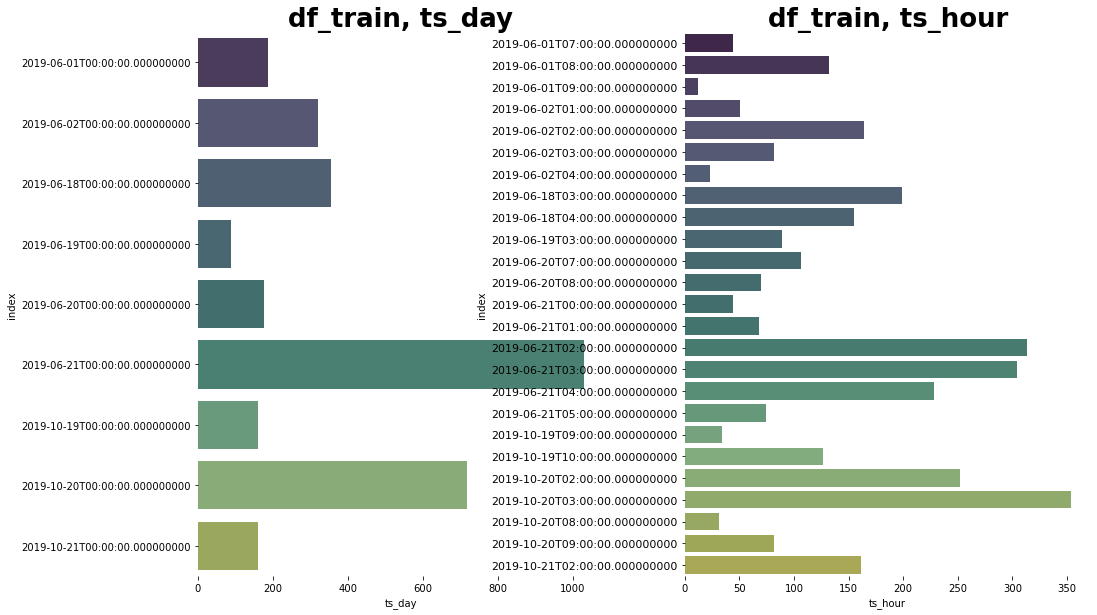

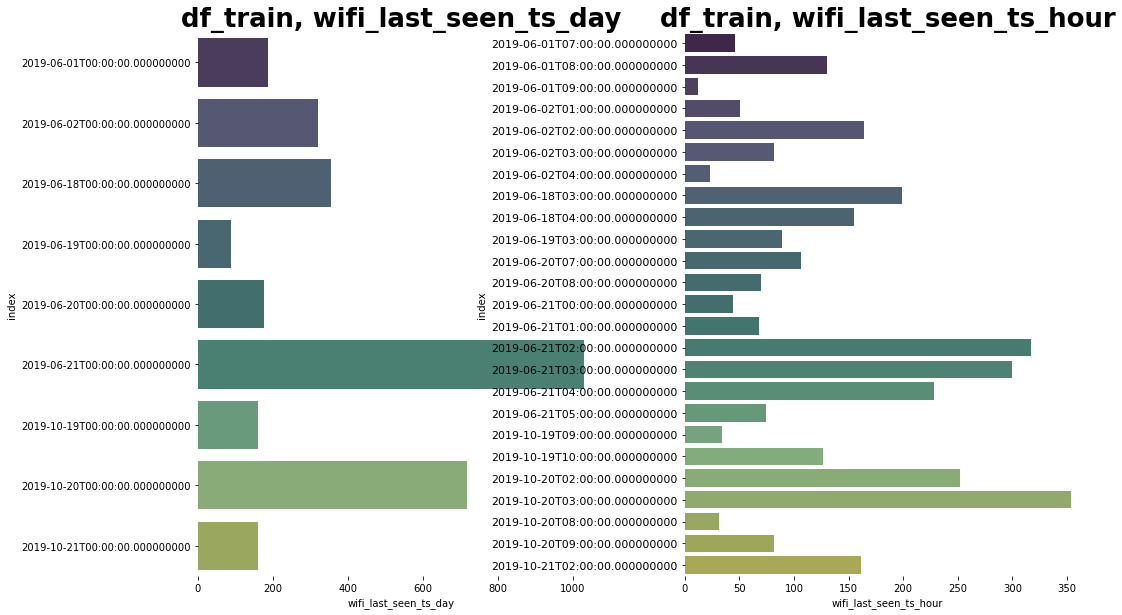

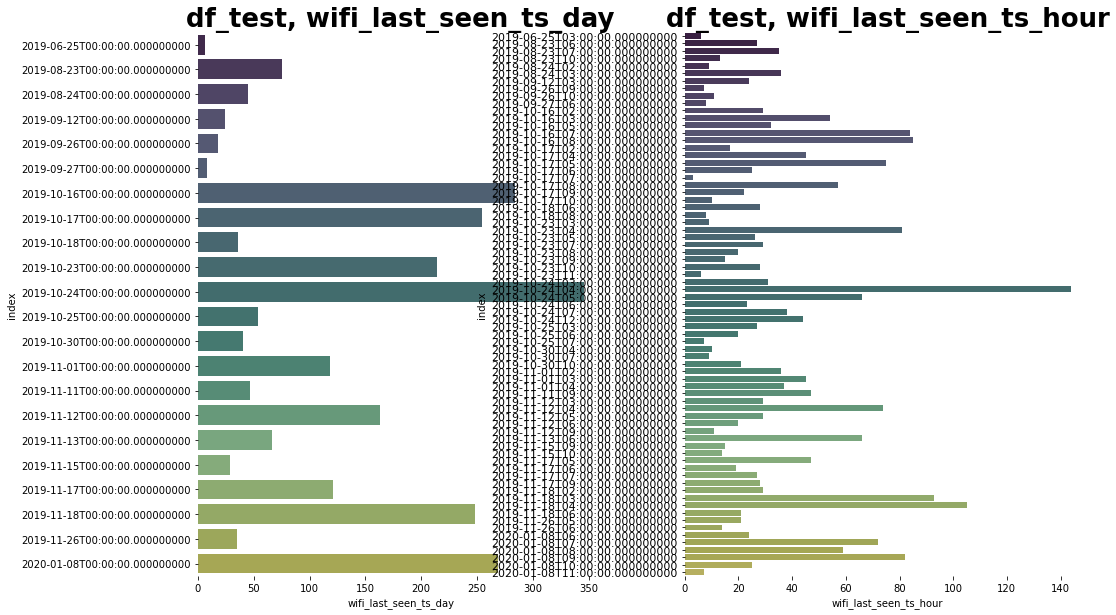

In [91]:
# Check wifi last seen distribution
plot_ts_frequency(df_train, ["ts_day", "ts_hour"])
plot_ts_frequency(df_train, ["wifi_last_seen_ts_day", "wifi_last_seen_ts_hour"])
plot_ts_frequency(df_test, ["wifi_last_seen_ts_day", "wifi_last_seen_ts_hour"])

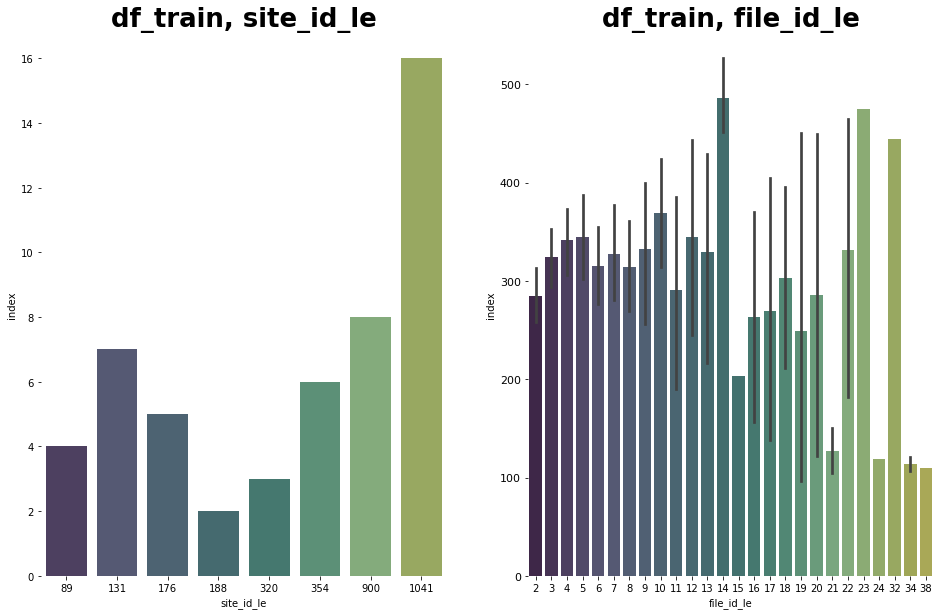

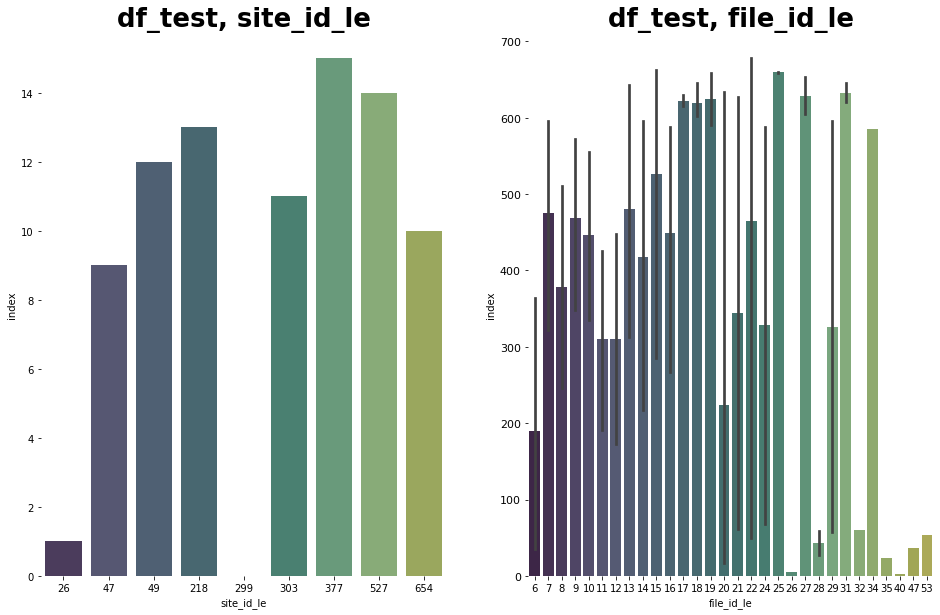

In [92]:
# Show site_id, file_id, wifi_ssid, wifi_bssid for train and test
plot_ts_frequency(df_combine_train, ["site_id_le", "file_id_le"])
plot_ts_frequency(df_combine_test, ["site_id_le", "file_id_le"])

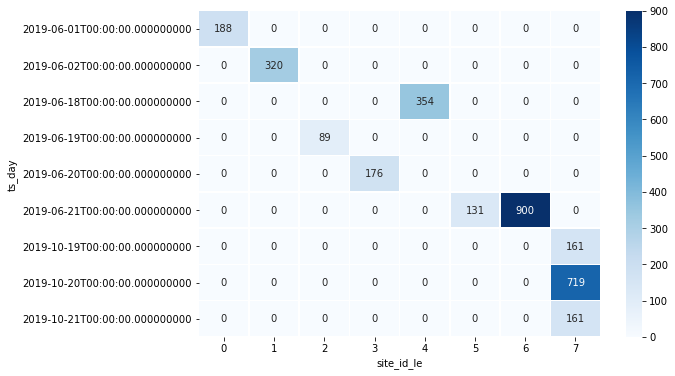

In [93]:
# Check dates distribution by heatmap -> Only train data because it uses ts
# Mostly one building is measured in one day, but has some exceptions like building "7" below
piv_df = df_train.pivot_table(index="ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

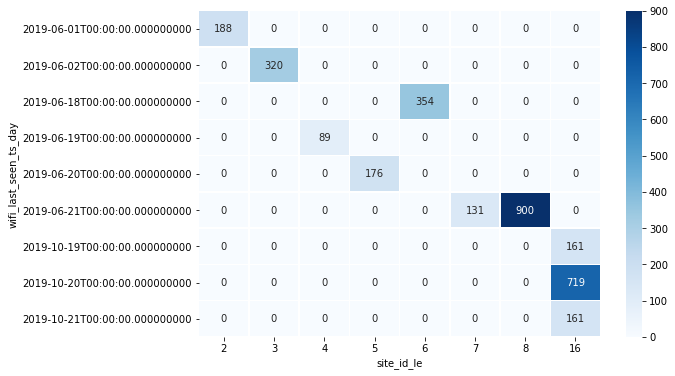

In [94]:
# Check dates distribution by heatmap with train data
piv_df = df_combine_train.pivot_table(index="wifi_last_seen_ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

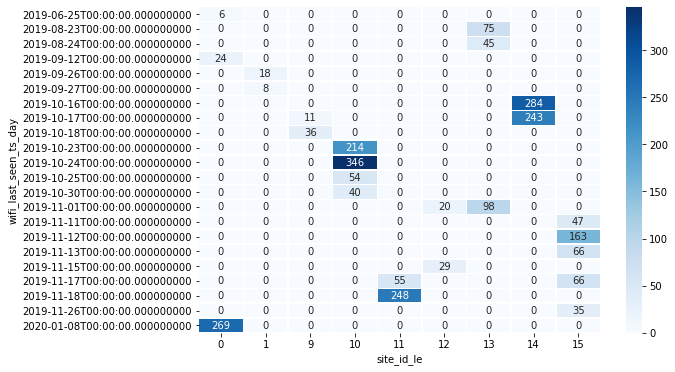

In [95]:
# Check dates distribution by heatmap with test data
# Result: No overlap in buildings between train and test, and how it can be measured on different dates is the same as well
piv_df = df_combine_test.pivot_table(index="wifi_last_seen_ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

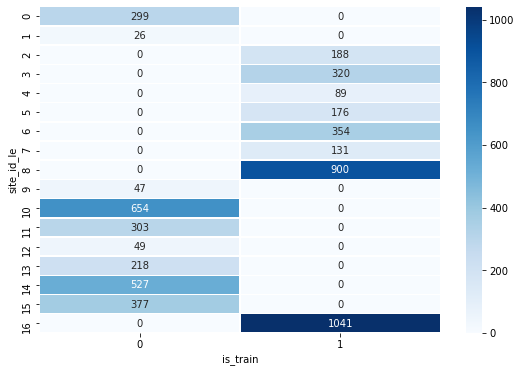

In [96]:
# Check for any overlap between train and test for site_id
# Result: No overlap of buildings 
piv_df = df_combine.pivot_table(index="site_id_le", columns="is_train", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

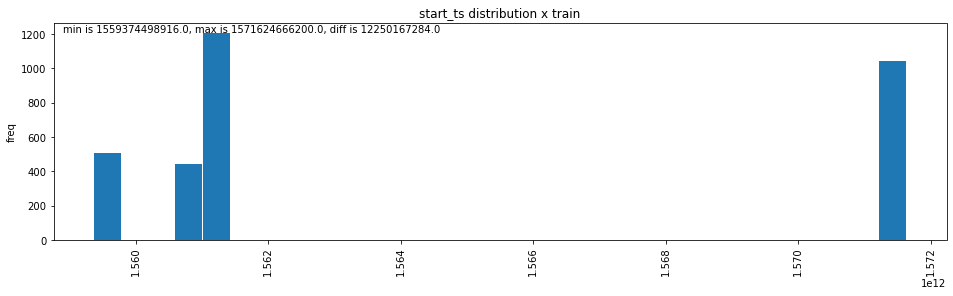

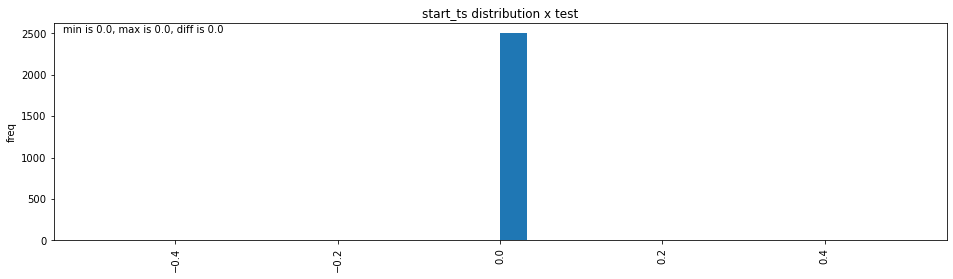

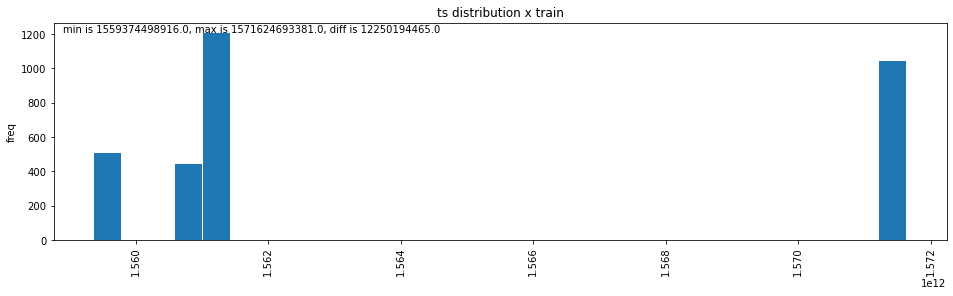

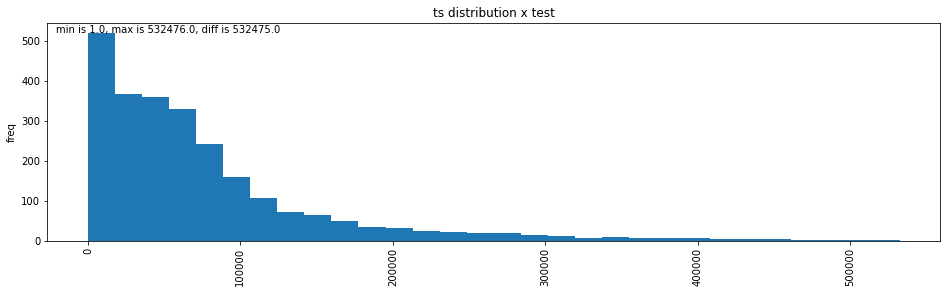

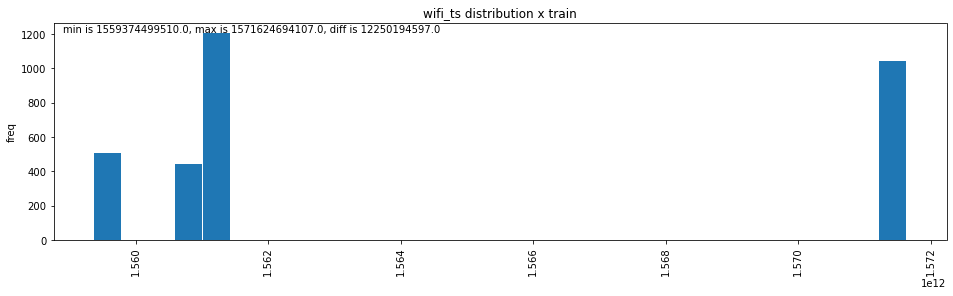

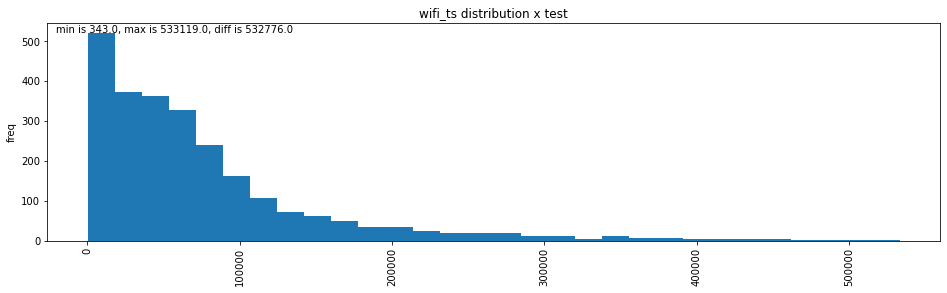

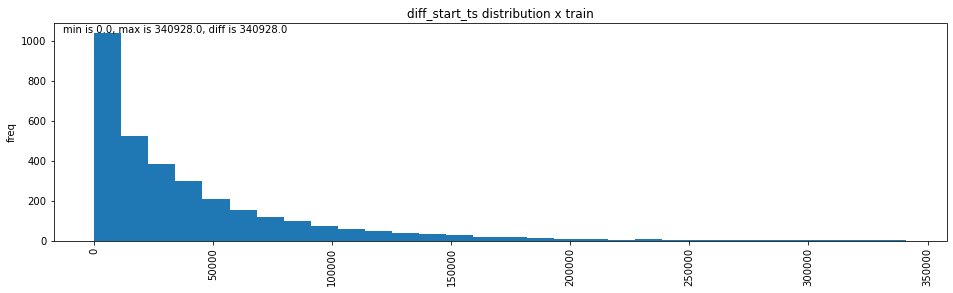

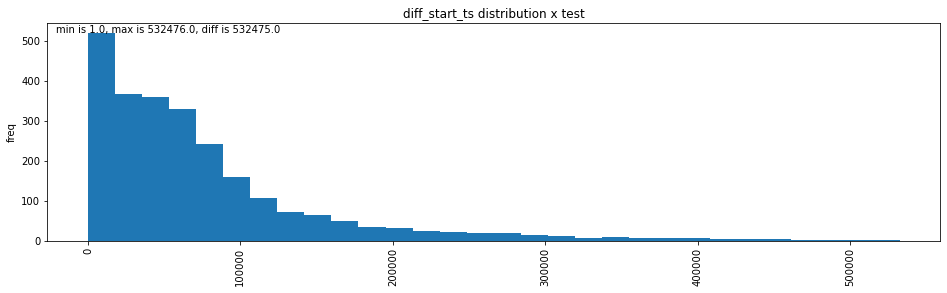

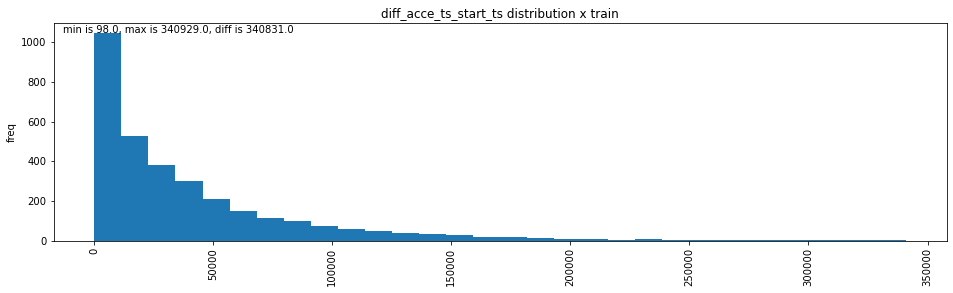

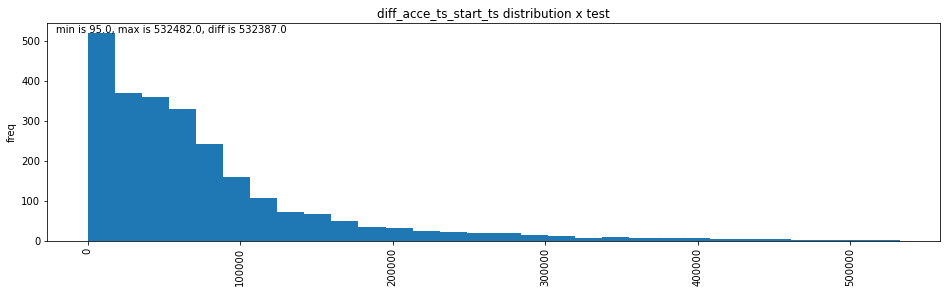

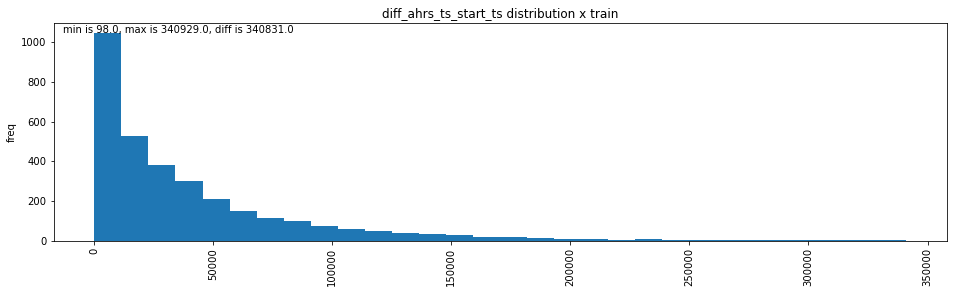

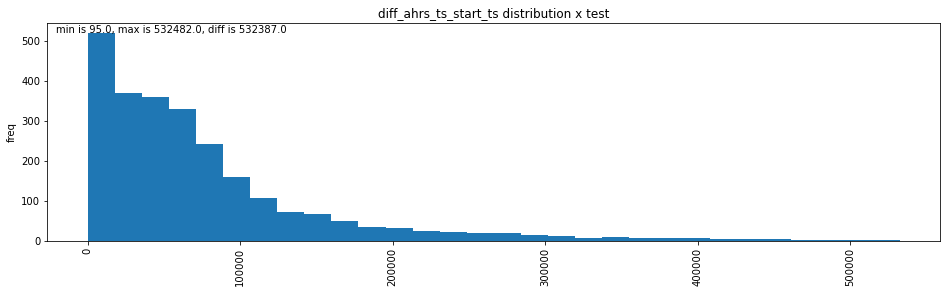

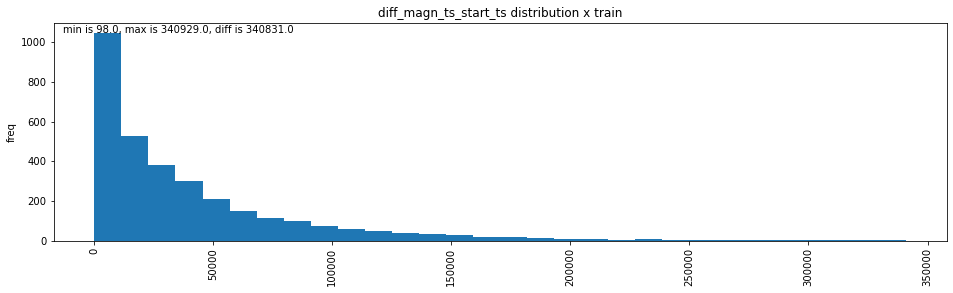

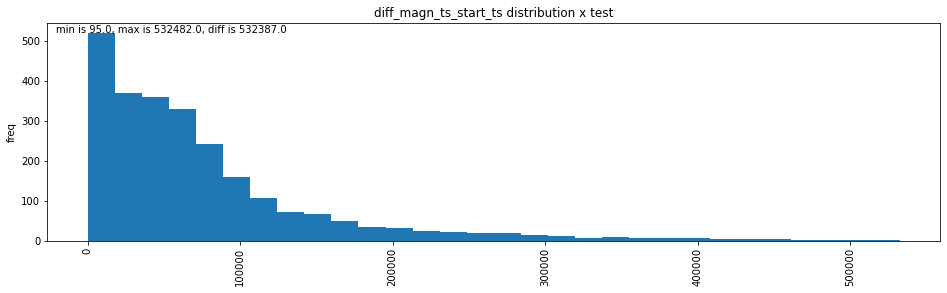

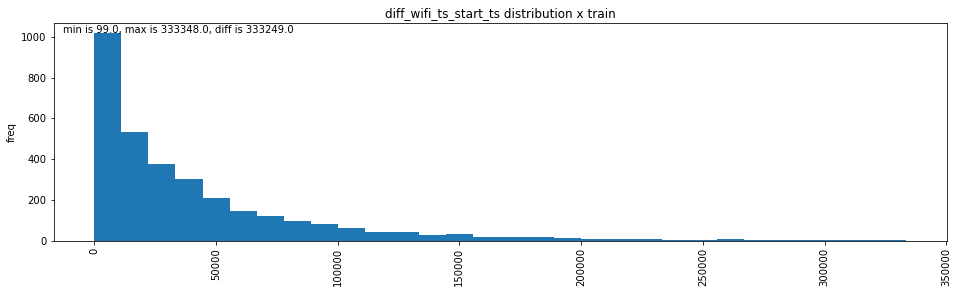

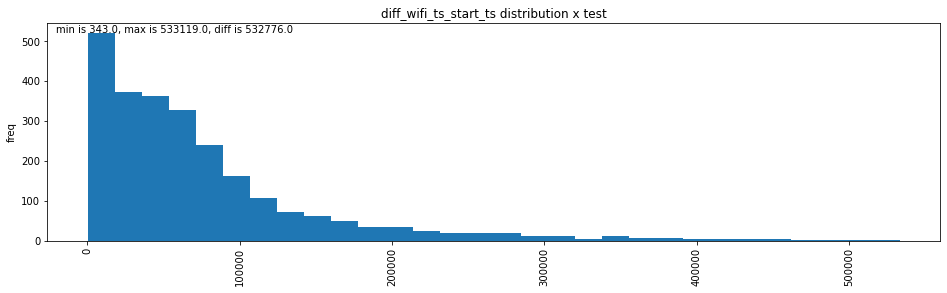

In [97]:
# bin and plot distribution : start_ts, ts, wifi_last_seen
# (don't plot them on the same scale)

# ["start_ts", "ts", "wifi_ts", "wifi_last_seen_ts"] distribution x [df_train, df_test]
start = time.time() # just in case
cols_to_plot = ["start_ts", "ts", "wifi_ts", "diff_start_ts", \
                "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"]

for col in cols_to_plot:
    for df in [df_train, df_test]:
        df_title = "train" if df.name == "df_train" else "test"
        bin_plot(df, col, f"{col} distribution x {df_title}", f"{col}", "freq")

# print("time to process", time.time() - start)

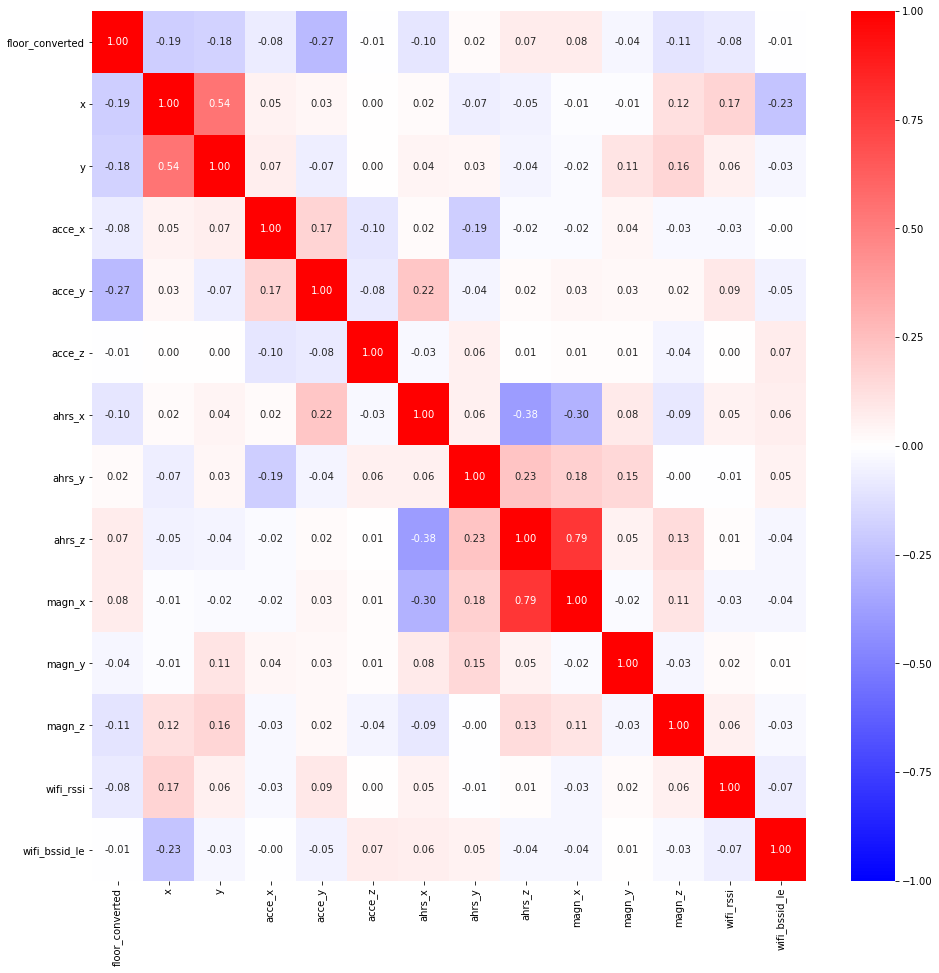

In [98]:
corr = df_train_num.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot=True,  cmap="bwr", ax=ax, fmt=".2f", robust=True, vmin=-1,vmax=1)
plt.show()

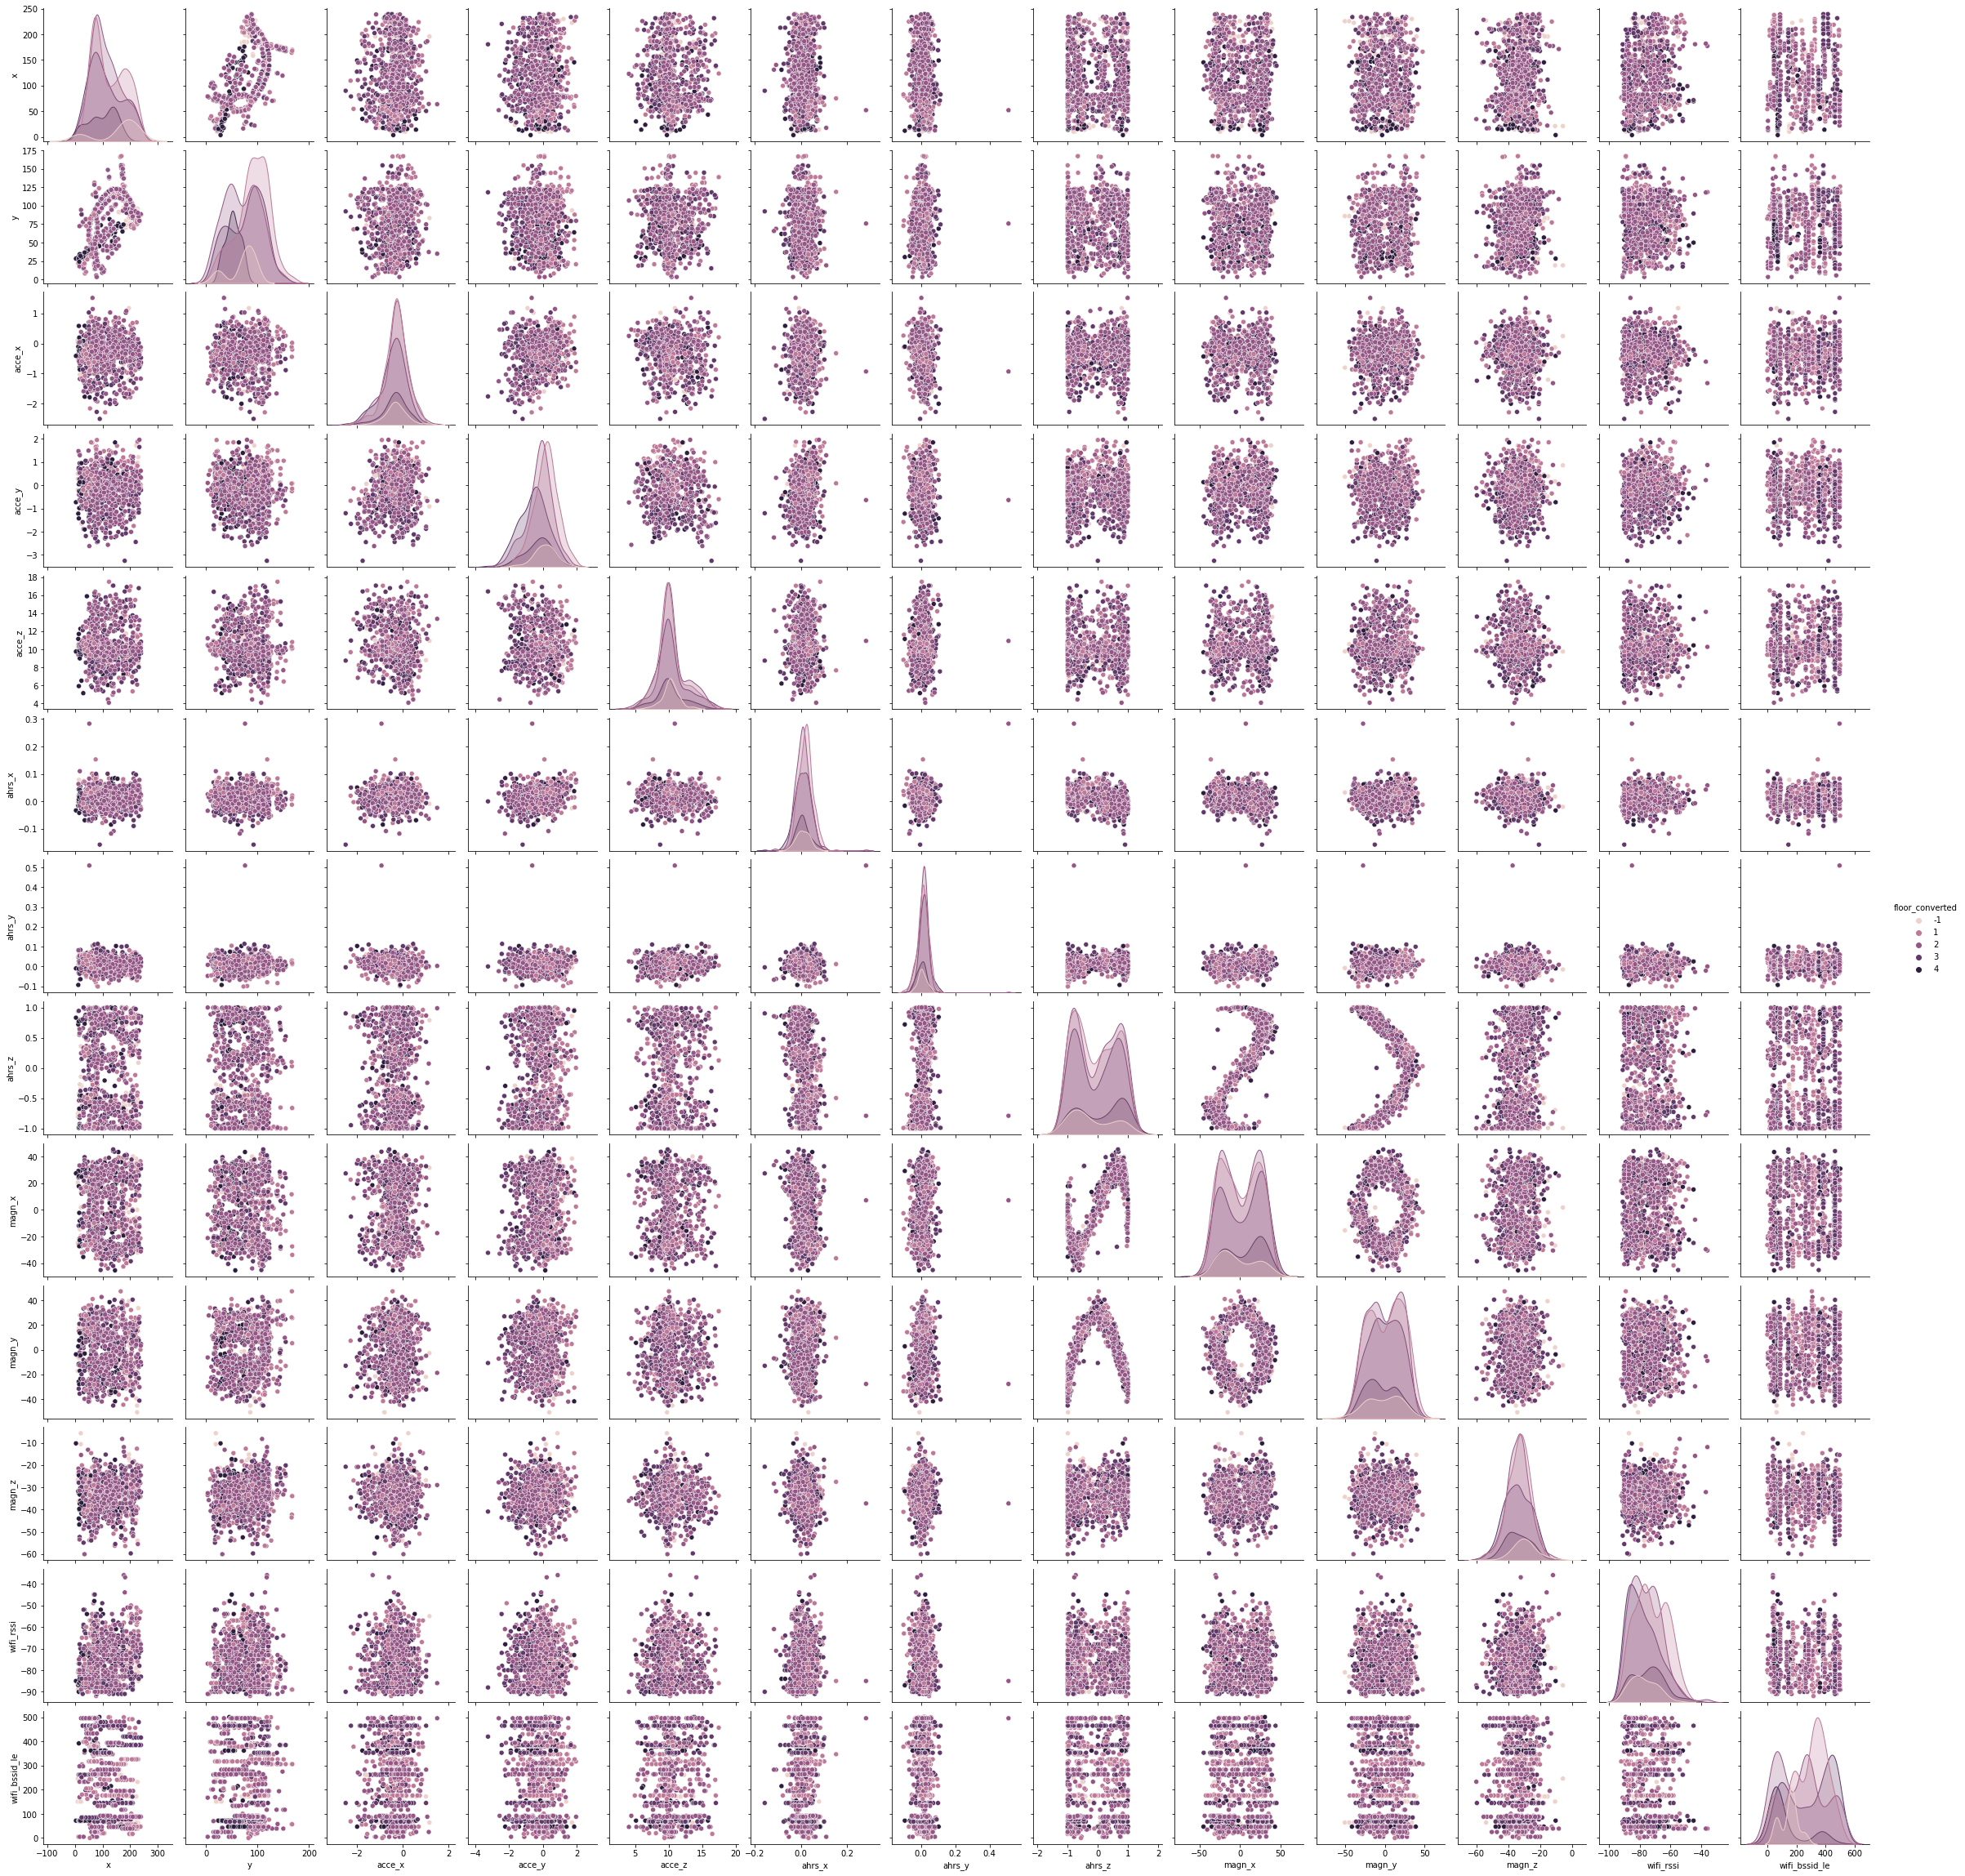

In [82]:
# pairplot by floor as hue using the numeric columns only
sns.pairplot(df_train_num, hue='floor_converted')

In [ ]:
# pairplot by building as hue
# Narrow combined df down to numeric ones only but this time keep site_id anf file_id
# sns.pairplot(df_combine_reduced, hue='site_id')

KeyboardInterrupt: 

In [ ]:
# Narrow combined df down to numeric ones only
display(df_combine_num.head())
sns.pairplot(df_combine_num, hue='is_train')